# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**

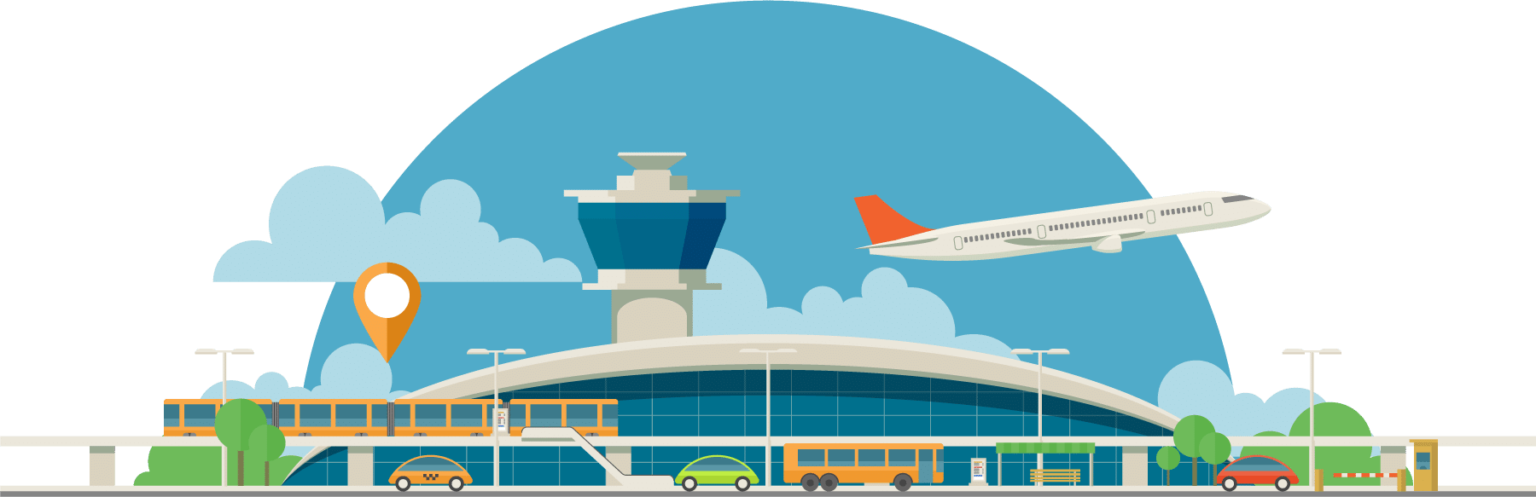

In [1]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

/Users/denis.bobylev/Documents/hse/ml-hw/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-02-01 18:00:44--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/Users/denis.bobylev/.postgresql/root.crt’

/Users/denis.bobyle 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-02-01 18:00:44 (126 MB/s) - ‘/Users/denis.bobylev/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

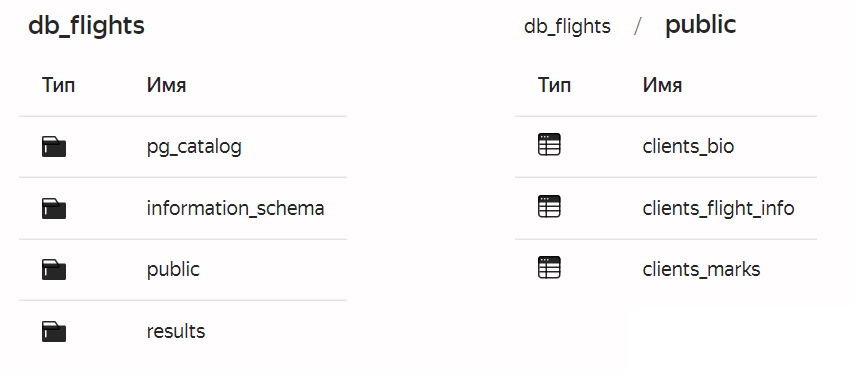



In [4]:
connection_params = {
    'host': 'rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
    'port': 6432,
    'sslmode': 'verify-full',
    'dbname': 'db_flights',
    'user': 'mlhs_student',
    'password': 'mlhs_student',
    'target_session_attrs': 'read-write'
}


query = '''
select
    clients_bio.id,
    clients_bio.gender,
    clients_bio.age,
    clients_flight_info."Customer Type",
    clients_flight_info."Type of Travel",
    clients_flight_info.class, clients_flight_info."Flight Distance",
    clients_flight_info."Departure Delay in Minutes",
    clients_flight_info."Arrival Delay in Minutes",
    clients_marks."Inflight wifi service",
    clients_marks."Departure/Arrival time convenient",
    clients_marks."Ease of Online booking",
    clients_marks."Gate location",
    clients_marks."Food and drink",
    clients_marks."Online boarding",
    clients_marks."Seat comfort",
    clients_marks."Inflight entertainment",
    clients_marks."On-board service",
    clients_marks."Leg room service",
    clients_marks."Baggage handling",
    clients_marks."Checkin service",
    clients_marks."Inflight service",
    clients_marks.cleanliness,
    clients_marks.satisfaction
from clients_bio
    left join clients_flight_info on clients_bio.id = clients_flight_info.id
    left join clients_marks on clients_bio.id = clients_marks.id'''

try:
    with psycopg2.connect(**connection_params) as connection:
        df = pd.read_sql_query(query, connection, index_col='id')
except Exception as e:
    print(f"Error: {e}")

/var/folders/_w/kwc87vq95knc__ftlw44x3kw0000gn/T/ipykernel_44677/1248023367.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection, index_col='id')


In [5]:
assert df.shape == (129_549, 23)

In [6]:
# replacing string 'nan's with np.nan
df = df.replace(to_replace=['nan'], value=np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129549 non-null  object
 1   age                                129234 non-null  object
 2   Customer Type                      129472 non-null  object
 3   Type of Travel                     129448 non-null  object
 4   class                              129433 non-null  object
 5   Flight Distance                    129455 non-null  object
 6   Departure Delay in Minutes         129442 non-null  object
 7   Arrival Delay in Minutes           129042 non-null  object
 8   Inflight wifi service              129505 non-null  object
 9   Departure/Arrival time convenient  129500 non-null  object
 10  Ease of Online booking             129506 non-null  object
 11  Gate location                      129512 non-null  objec

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

```
1) Преобразование числовых столбцов в float
```

In [7]:
# to float
columns_to_convert = df.columns.difference(['gender', 'Customer Type', 'Type of Travel', 'class', 'satisfaction'])
df[columns_to_convert] = df[columns_to_convert].astype(float)

In [8]:
# info to check types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129472 non-null  object 
 3   Type of Travel                     129448 non-null  object 
 4   class                              129433 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      129512 no

```
2) Пропуски
```

In [9]:
# missing values
df[df.columns[df.isna().any()]].isna().sum()

age                                  315
Customer Type                         77
Type of Travel                       101
class                                116
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
dtype: int64

```
3) Выбросы
```

In [10]:
df.describe(include='all')

gender            age   Customer Type   Type of Travel     class  \
count   129549  129234.000000          129472           129448    129433   
unique       2            NaN               2                2         3   
top     Female            NaN  Loyal Customer  Business travel  Business   
freq     65726            NaN          105763            89405     61939   
mean       NaN      40.116951             NaN              NaN       NaN   
std        NaN      20.376129             NaN              NaN       NaN   
min        NaN       0.000000             NaN              NaN       NaN   
25%        NaN      27.000000             NaN              NaN       NaN   
50%        NaN      40.000000             NaN              NaN       NaN   
75%        NaN      51.000000             NaN              NaN       NaN   
max        NaN     621.000000             NaN              NaN       NaN   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
count     129455.000000               129442.000000             129042.000000   
unique              NaN                         NaN                       NaN   
top                 NaN                         NaN                       NaN   
freq                NaN                         NaN                       NaN   
mean        1322.922158                   15.809026                 16.656499   
std         4517.816532                   93.276882                109.285072   
min            0.000000                    0.000000                  0.000000   
25%          414.000000                    0.000000                  0.000000   
50%          846.000000                    0.000000                  0.000000   
75%         1744.000000                   12.000000                 13.000000   
max       379620.000000                22227.000000              14006.000000   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
count           129505.000000                      129500.000000  ...   
unique                    NaN                                NaN  ...   
top                       NaN                                NaN  ...   
freq                      NaN                                NaN  ...   
mean                 2.732327                           3.062131  ...   
std                  1.360033                           1.559627  ...   
min                  0.000000                           0.000000  ...   
25%                  2.000000                           2.000000  ...   
50%                  3.000000                           3.000000  ...   
75%                  4.000000                           4.000000  ...   
max                 45.000000                          45.000000  ...   

        Online boarding   Seat comfort  Inflight entertainment  \
count     129503.000000  129502.000000           129504.000000   
unique              NaN            NaN                     NaN   
top                 NaN            NaN                     NaN   
freq                NaN            NaN                     NaN   
mean           3.256782       3.445669                3.361232   
std            1.381888       1.349713                1.366908   
min            0.000000       0.000000                0.000000   
25%            2.000000       2.000000                2.000000   
50%            3.000000       4.000000                4.000000   
75%            4.000000       5.000000                4.000000   
max           40.000000      45.000000               45.000000   

        On-board service  Leg room service  Baggage handling  Checkin service  \
count      129505.000000     129503.000000     129501.000000    129507.000000   
unique               NaN               NaN               NaN              NaN   
top                  NaN               NaN               NaN              NaN   
freq                 NaN               NaN               NaN              NaN   
mean            3.387259          3.355976     

```
Выбросы одназначно есть, это можно видеть по колонкам:
  * age, где максимальный возраст равен 621;
  * Flight Distance, где максимальная дистанция полета равна 379620;
  * Departure Delay in Minutes
  * Arrival Delay in Minutes
```

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

```
1) matrix пропущенных значений;
```

<Figure size 5200x300 with 0 Axes>

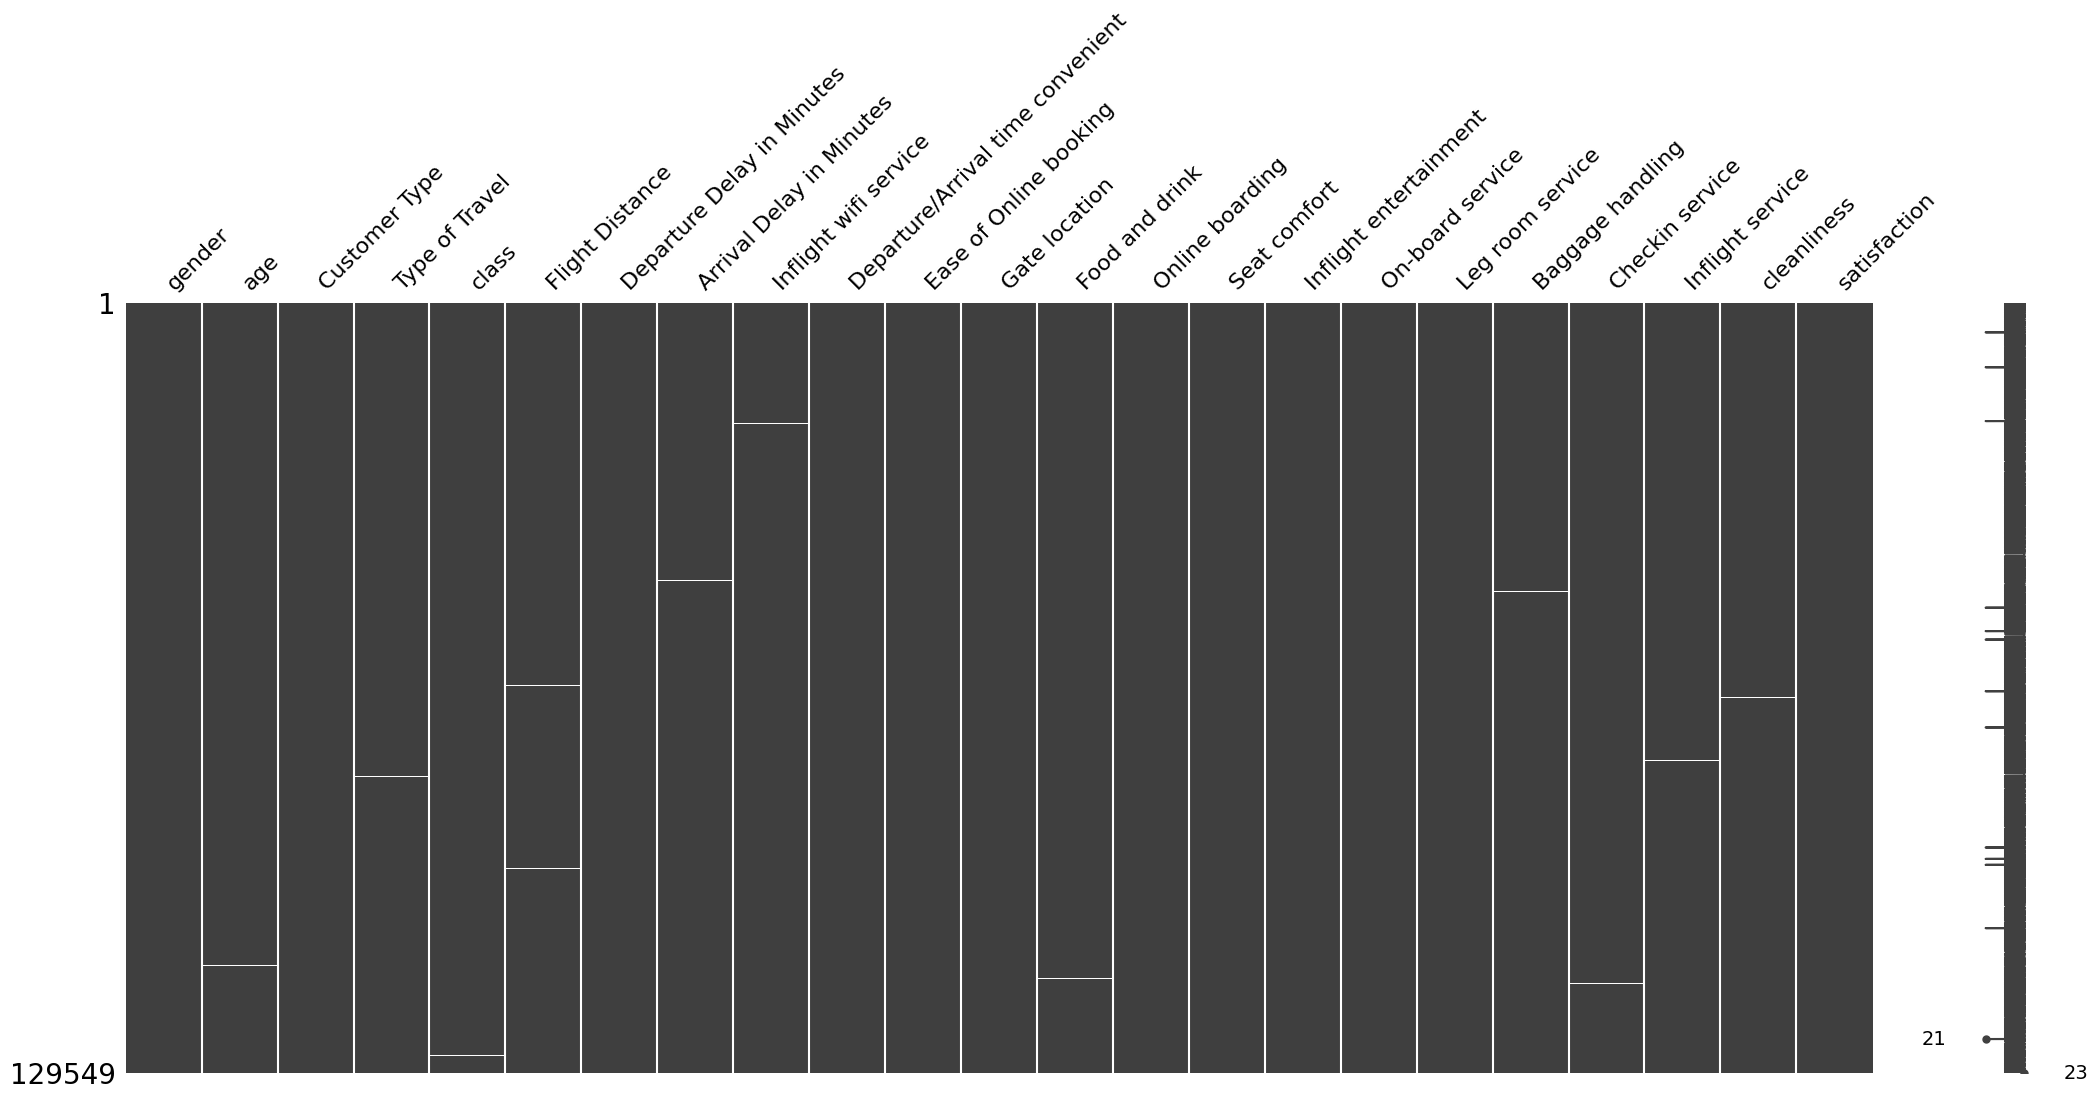

In [11]:
# matrix
plt.figure(figsize=(52, 3))
missingno.matrix(df)
plt.show()

```
2) столбчатая диаграмма в логарифмированной шкале
```

/Users/denis.bobylev/Documents/hse/ml-hw/venv/lib/python3.12/site-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


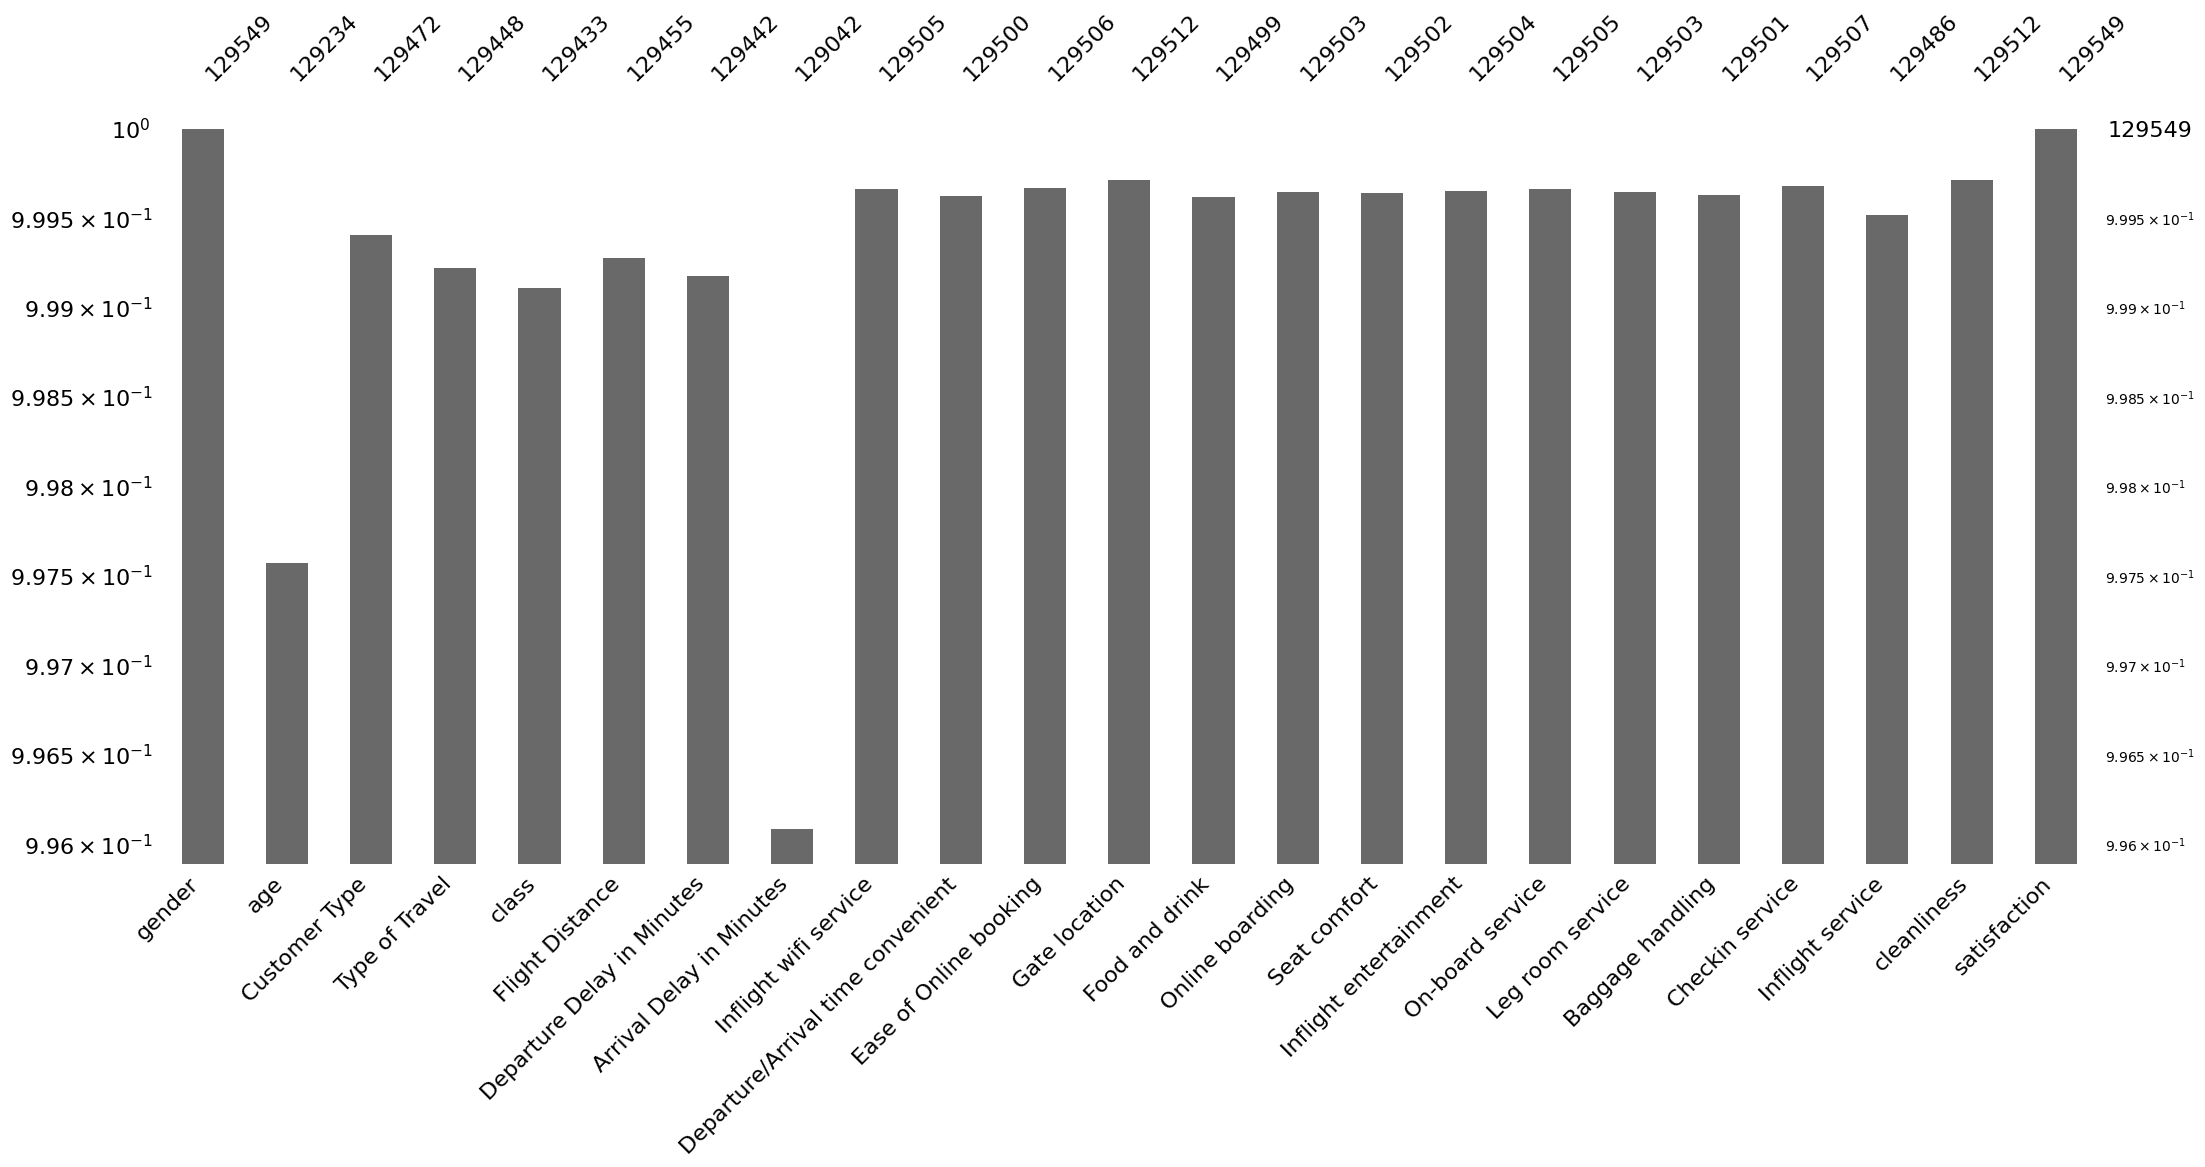

In [12]:
plt.figure(figsize=(5, 3))
missingno.bar(df, log=True)
plt.show()

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [13]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129831  Female  28.0     Loyal Customer  Personal Travel       Eco   
129837    Male  66.0     Loyal Customer  Personal Travel       Eco   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129831            447.0                        23.0                      16.0   
129837            337.0                       199.0                     213.0   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
7                         3.0                                3.0  ...   
13                        2.0                                2.0  ...   
18                        2.0                                5.0  ...   
31                        2.0                                2.0  ...   
39                        3.0                                3.0  ...   
...                       ...                                ...  ...   
129831                    1.0                                3.0  ...   
129837                    2.0                                4.0  ...   
129838                    3.0                                5.0  ...   
129839                    2.0                                4.0  ...   
129846                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0                     5.0   
31                  2.0           2.0                     2.0   
39                  5.0           4.0                     4.0   
...                 ...           ...                     ...   
129831              1.0           3.0                     3.0   
129837              5.0           5.0                     5.0   
129838              5.0           5.0                     3.0   
129839              2.0           3.0                     3.0   
129846              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
7                    5.0               5.0               5.0              4.0   
13  

In [14]:
assert df_train.shape == (103_644, 23)

In [15]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
id                                                                
55        Male  36.0  Loyal Customer  Business travel  Business   
79      Female  70.0  Loyal Customer  Personal Travel       Eco   
126       Male  66.0  Loyal Customer  Personal Travel       Eco   
199     Female  60.0  Loyal Customer  Business travel  Business   
263       Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129750    Male  38.0  Loyal Customer  Business travel       Eco   
129771    Male  16.0  Loyal Customer  Personal Travel       Eco   
129798  Female  43.0  Loyal Customer  Personal Travel       Eco   
129868    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
55               3655.0                        40.0                      71.0   
79                108.0                        50.0                      41.0   
126               562.0                        88.0                      84.0   
199              3756.0                        36.0                      24.0   
263               802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129750            337.0                        92.0                      82.0   
129771            308.0                         2.0                       0.0   
129798            308.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
55                        1.0                                1.0  ...   
79                        5.0                                4.0  ...   
126                       2.0                                5.0  ...   
199                       4.0                                4.0  ...   
263                       1.0                                2.0  ...   
...                       ...                                ...  ...   
129750                    4.0                                3.0  ...   
129771                    3.0                                4.0  ...   
129798                    2.0                                4.0  ...   
129868                    3.0                                4.0  ...   
129876                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                              
55                 1.0              3.0           3.0                     3.0   
79                 4.0              4.0           4.0                     3.0   
126                5.0              2.0           5.0                     5.0   
199                2.0              4.0           5.0                     4.0   
263                2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129750             4.0              5.0           4.0                     4.0   
129771             1.0              3.0           5.0                     1.0   
129798             3.0              5.0           5.0                     4.0   
129868             4.0              3.0           4.0                     4.0   
129876             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service 

In [16]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [17]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [18]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

```
Реализуем ImputerFillNAWithMode в виде, пригодном для использования в пайплайнах
```

In [19]:
from sklearn.base import BaseEstimator


class ImputerFillNAWithMode(BaseEstimator):
    def __init__(self):
        self.X_fillna = {}

    def fit(self, X, y=None):
        for column in X.columns:
            if X[column].isnull().any():
                self.X_fillna[column] = X[column].mode()[0]
        return self

    def transform(self, X):
        for col, val in self.X_fillna.items():
            X[col] = X[col].fillna(val)
        return X

```
Обучаем на train выборке, применяем на validate выборке
```

In [20]:
imputer = ImputerFillNAWithMode()
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_val = imputer.transform(X_val)

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72550 entries, 2031 to 28513
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             72550 non-null  object 
 1   age                                72550 non-null  float64
 2   Customer Type                      72550 non-null  object 
 3   Type of Travel                     72550 non-null  object 
 4   class                              72550 non-null  object 
 5   Flight Distance                    72550 non-null  float64
 6   Departure Delay in Minutes         72550 non-null  float64
 7   Arrival Delay in Minutes           72550 non-null  float64
 8   Inflight wifi service              72550 non-null  float64
 9   Departure/Arrival time convenient  72550 non-null  float64
 10  Ease of Online booking             72550 non-null  float64
 11  Gate location                      72550 non-null  float

In [22]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31094 entries, 62191 to 122474
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             31094 non-null  object 
 1   age                                31094 non-null  float64
 2   Customer Type                      31094 non-null  object 
 3   Type of Travel                     31094 non-null  object 
 4   class                              31094 non-null  object 
 5   Flight Distance                    31094 non-null  float64
 6   Departure Delay in Minutes         31094 non-null  float64
 7   Arrival Delay in Minutes           31094 non-null  float64
 8   Inflight wifi service              31094 non-null  float64
 9   Departure/Arrival time convenient  31094 non-null  float64
 10  Ease of Online booking             31094 non-null  float64
 11  Gate location                      31094 non-null  flo

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

```
Основные статистики по числовым столбцам
(можно было бы выводить по всем сразу, через include='all', но по отдельности более наглядно)
```

In [23]:
df.describe(include='number')

age  Flight Distance  Departure Delay in Minutes  \
count  129234.000000    129455.000000               129442.000000   
mean       40.116951      1322.922158                   15.809026   
std        20.376129      4517.816532                   93.276882   
min         0.000000         0.000000                    0.000000   
25%        27.000000       414.000000                    0.000000   
50%        40.000000       846.000000                    0.000000   
75%        51.000000      1744.000000                   12.000000   
max       621.000000    379620.000000                22227.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count             129042.000000          129505.000000   
mean                  16.656499               2.732327   
std                  109.285072               1.360033   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      129500.000000           129506.000000   
mean                            3.062131                2.760722   
std                             1.559627                1.431048   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               45.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  129512.000000   129499.000000    129503.000000  129502.000000   
mean        2.981708        3.208141         3.256782       3.445669   
std         1.312873        1.357546         1.381888       1.349713   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max        36.000000       45.000000        40.000000      45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           129504.000000     129505.000000     129503.000000   
mean                 3.361232          3.387259          3.355976   
std                  1.366908          1.335697          1.361670   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 45.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service    cleanliness  
count     129501.000000    129507.000000     129486.000000  129512.000000  
mean           3.635872         3.309976          3.646927       3.289780  
std            1.222039         1.298827          1.218748       1.347466  
min            0.000000         0.000000          0.000000       0.000000  
25%            3.000000         3.000000          3.000000       2.000000  
50%            4.000000         3.000000          4.000000       3.000000  
75%            5.000000         4.000000          5.000000       4.000000  
max           40.000000        45.000000         40.000000      45.000000

```
Основные статистики по категориальным столбцам
```

In [24]:
df.describe(include='object')

gender   Customer Type   Type of Travel     class  \
count   129549          129472           129448    129433   
unique       2               2                2         3   
top     Female  Loyal Customer  Business travel  Business   
freq     65726          105763            89405     61939   

                   satisfaction  
count                    129549  
unique                        3  
top     neutral or dissatisfied  
freq                      58732

Сложно сделать вывод о распределениях без графиков, могу сказать, что распределение age похоже на нормальное - большинство наблюдений сосредоточены около среднего значения. Но также есть и выбросы (max age = 621). Другие признаки имеют высокий разброс и выбросы, сложно сделать вывод.



### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [25]:
class OutlierRemovalByQuantile:
    def __init__(self, quantile=0.996):
        self.quantile = quantile
        self.upper_limits = {}

    def fit(self, X, y=None):
        numeric_cols = X.select_dtypes(include=['number']).columns
        for col in numeric_cols:
            self.upper_limits[col] = X[col].quantile(self.quantile)
        return self

    def transform(self, X, y):
        X_cleaned = X.copy()
        for col, upper_limit in self.upper_limits.items():
            X_cleaned = X_cleaned[X_cleaned[col] <= upper_limit]
        y_cleaned = y[X_cleaned.index]
        return X_cleaned, y_cleaned


In [26]:
outlier_remover = OutlierRemovalByQuantile(quantile=0.996)
outlier_remover.fit(X_train)
X_train, y_train = outlier_remover.transform(X_train, y_train)
X_val, y_val = outlier_remover.transform(X_val, y_val)

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71395 entries, 2031 to 28513
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             71395 non-null  object 
 1   age                                71395 non-null  float64
 2   Customer Type                      71395 non-null  object 
 3   Type of Travel                     71395 non-null  object 
 4   class                              71395 non-null  object 
 5   Flight Distance                    71395 non-null  float64
 6   Departure Delay in Minutes         71395 non-null  float64
 7   Arrival Delay in Minutes           71395 non-null  float64
 8   Inflight wifi service              71395 non-null  float64
 9   Departure/Arrival time convenient  71395 non-null  float64
 10  Ease of Online booking             71395 non-null  float64
 11  Gate location                      71395 non-null  float

In [28]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [29]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [30]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [31]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    n = len(cols)
    ncols = 3
    nrows = (n // ncols) + (1 if n % ncols != 0 else 0)

    plt.figure(figsize=(ncols * 4, nrows * 4))
    for i, col in enumerate(cols):
        plt.subplot(nrows, ncols, i + 1)
        sns.countplot(x=col, data=df, hue=y, palette='coolwarm')
        plt.title(f'Countplot of {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.show()

In [32]:
def plot_continuous(cols, df, y=None):
    """Draws kdeplots and boxplots in one row for all columns in 'cols' with informative title"""
    n = len(cols)
    ncols = 2
    nrows = (n * 2 // ncols) + (1 if (n * 2) % ncols != 0 else 0)

    plt.figure(figsize=(ncols * 4, nrows * 4))
    for i, col in enumerate(cols):
        plt.subplot(nrows, ncols, 2 * i + 1)
        sns.kdeplot(data=df, x=col, hue=y, fill=True, palette='Blues', common_norm=False)
        plt.title(f'KDE Plot of {col}')

        plt.subplot(nrows, ncols, 2 * i + 2)
        sns.boxplot(x=col, data=df, hue=y, palette='Set2')
        plt.title(f'Boxplot of {col}')

        plt.tight_layout()

    plt.show()

In [33]:
def plot_categorical(cols, df, y=None):
    """Draws countplots for all columns in 'cols' with informative title"""

    n = len(cols)
    ncols = 3
    nrows = (n // ncols) + (1 if n % ncols != 0 else 0)

    plt.figure(figsize=(ncols * 5, nrows * 5))

    for i, col in enumerate(cols):
        plt.subplot(nrows, ncols, i + 1)

        sns.countplot(x=col, data=df, hue=y, palette='Set2')

        plt.title(f'Countplot of {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.show()

In [34]:
def plot_target_distribution(target, target_name):
    """Visualizes the distribution of the target variable"""
    plt.figure(figsize=(8, 6))

    sns.countplot(x=target, hue=target, palette='Set2', legend=False)

    plt.title(f'Distribution of {target_name}')
    plt.xlabel(target_name)
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

Отрисовка.

In [35]:
categorical_cols

['gender', 'Customer Type', 'Type of Travel', 'class']

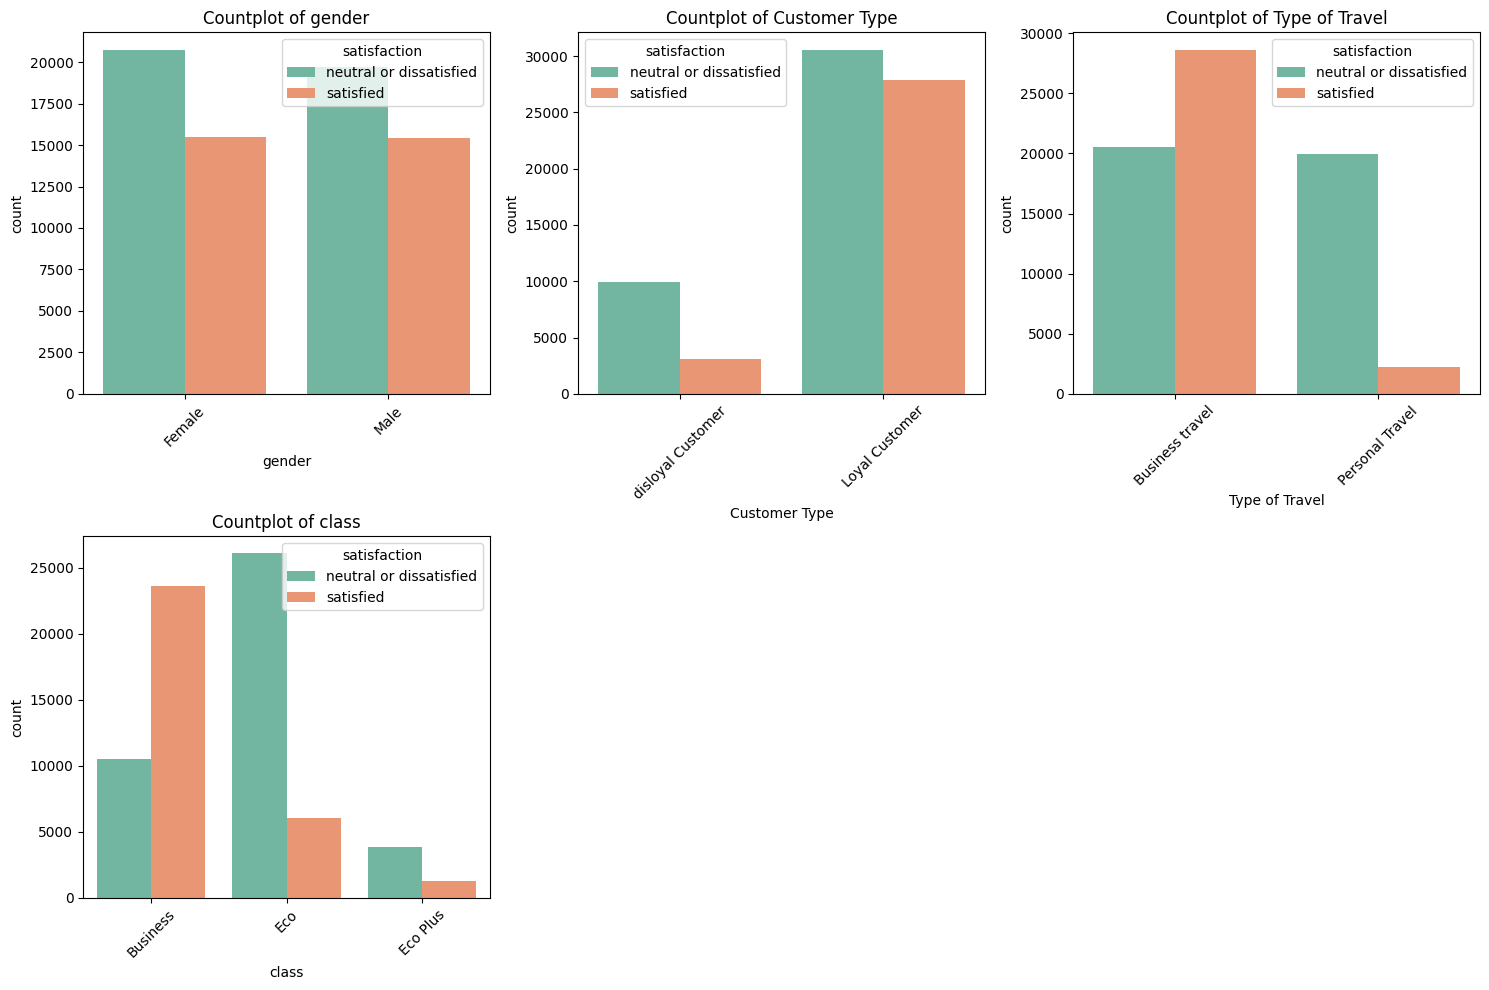

In [36]:
plot_categorical(categorical_cols, X_train, y_train)

In [37]:
continuous_cols

['age',
 'Flight Distance',
 'Departure Delay in Minutes',
 'Arrival Delay in Minutes']

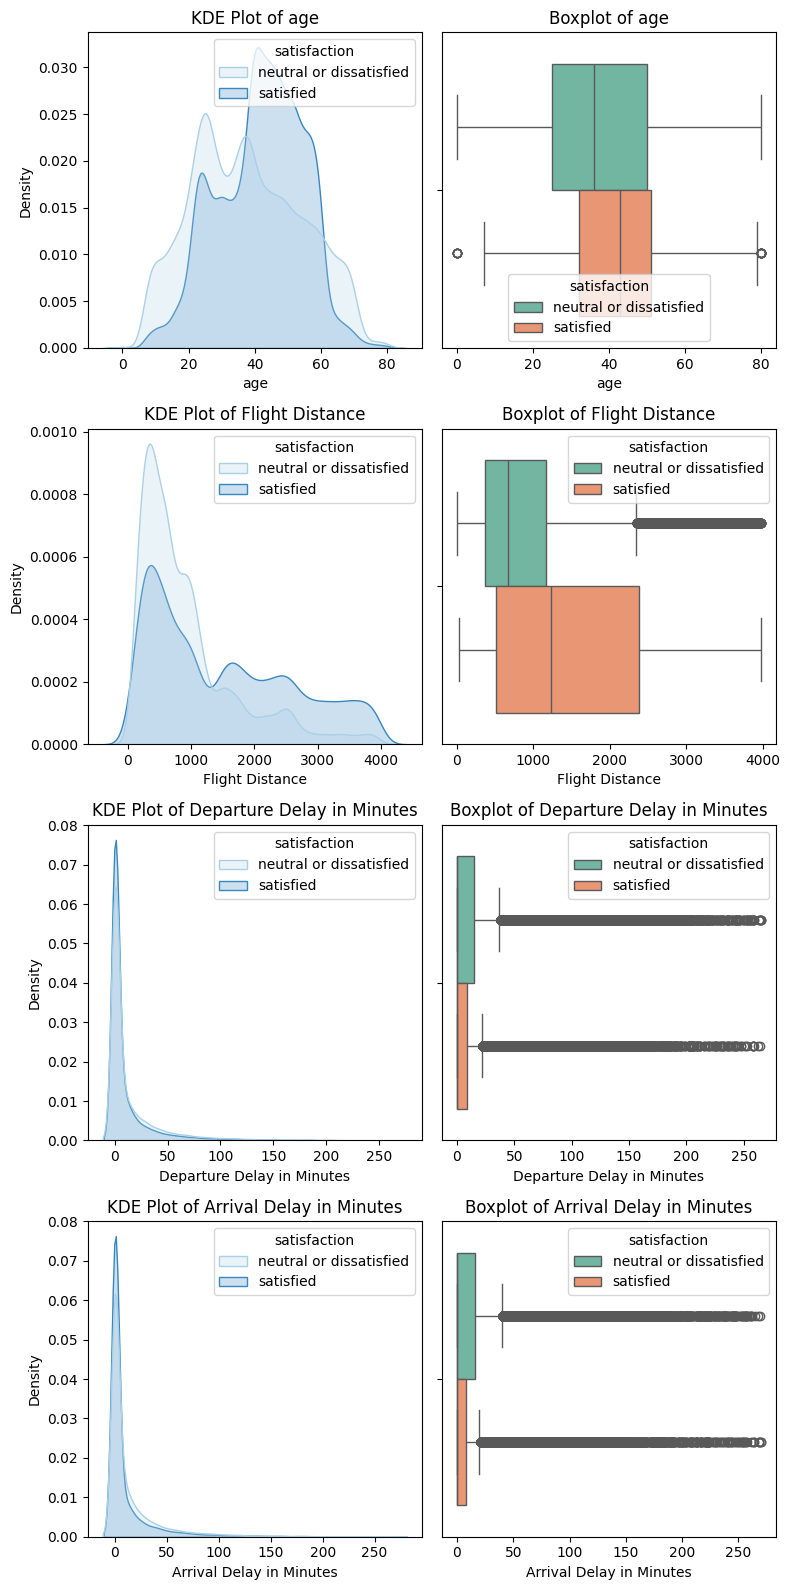

In [38]:
plot_continuous(continuous_cols, X_train, y_train)

In [39]:
ordinal_cols

['Gate location',
 'Leg room service',
 'cleanliness',
 'Food and drink',
 'Online boarding',
 'On-board service',
 'Inflight wifi service',
 'Seat comfort',
 'Departure/Arrival time convenient',
 'Checkin service',
 'Inflight service',
 'Ease of Online booking',
 'Inflight entertainment',
 'Baggage handling']

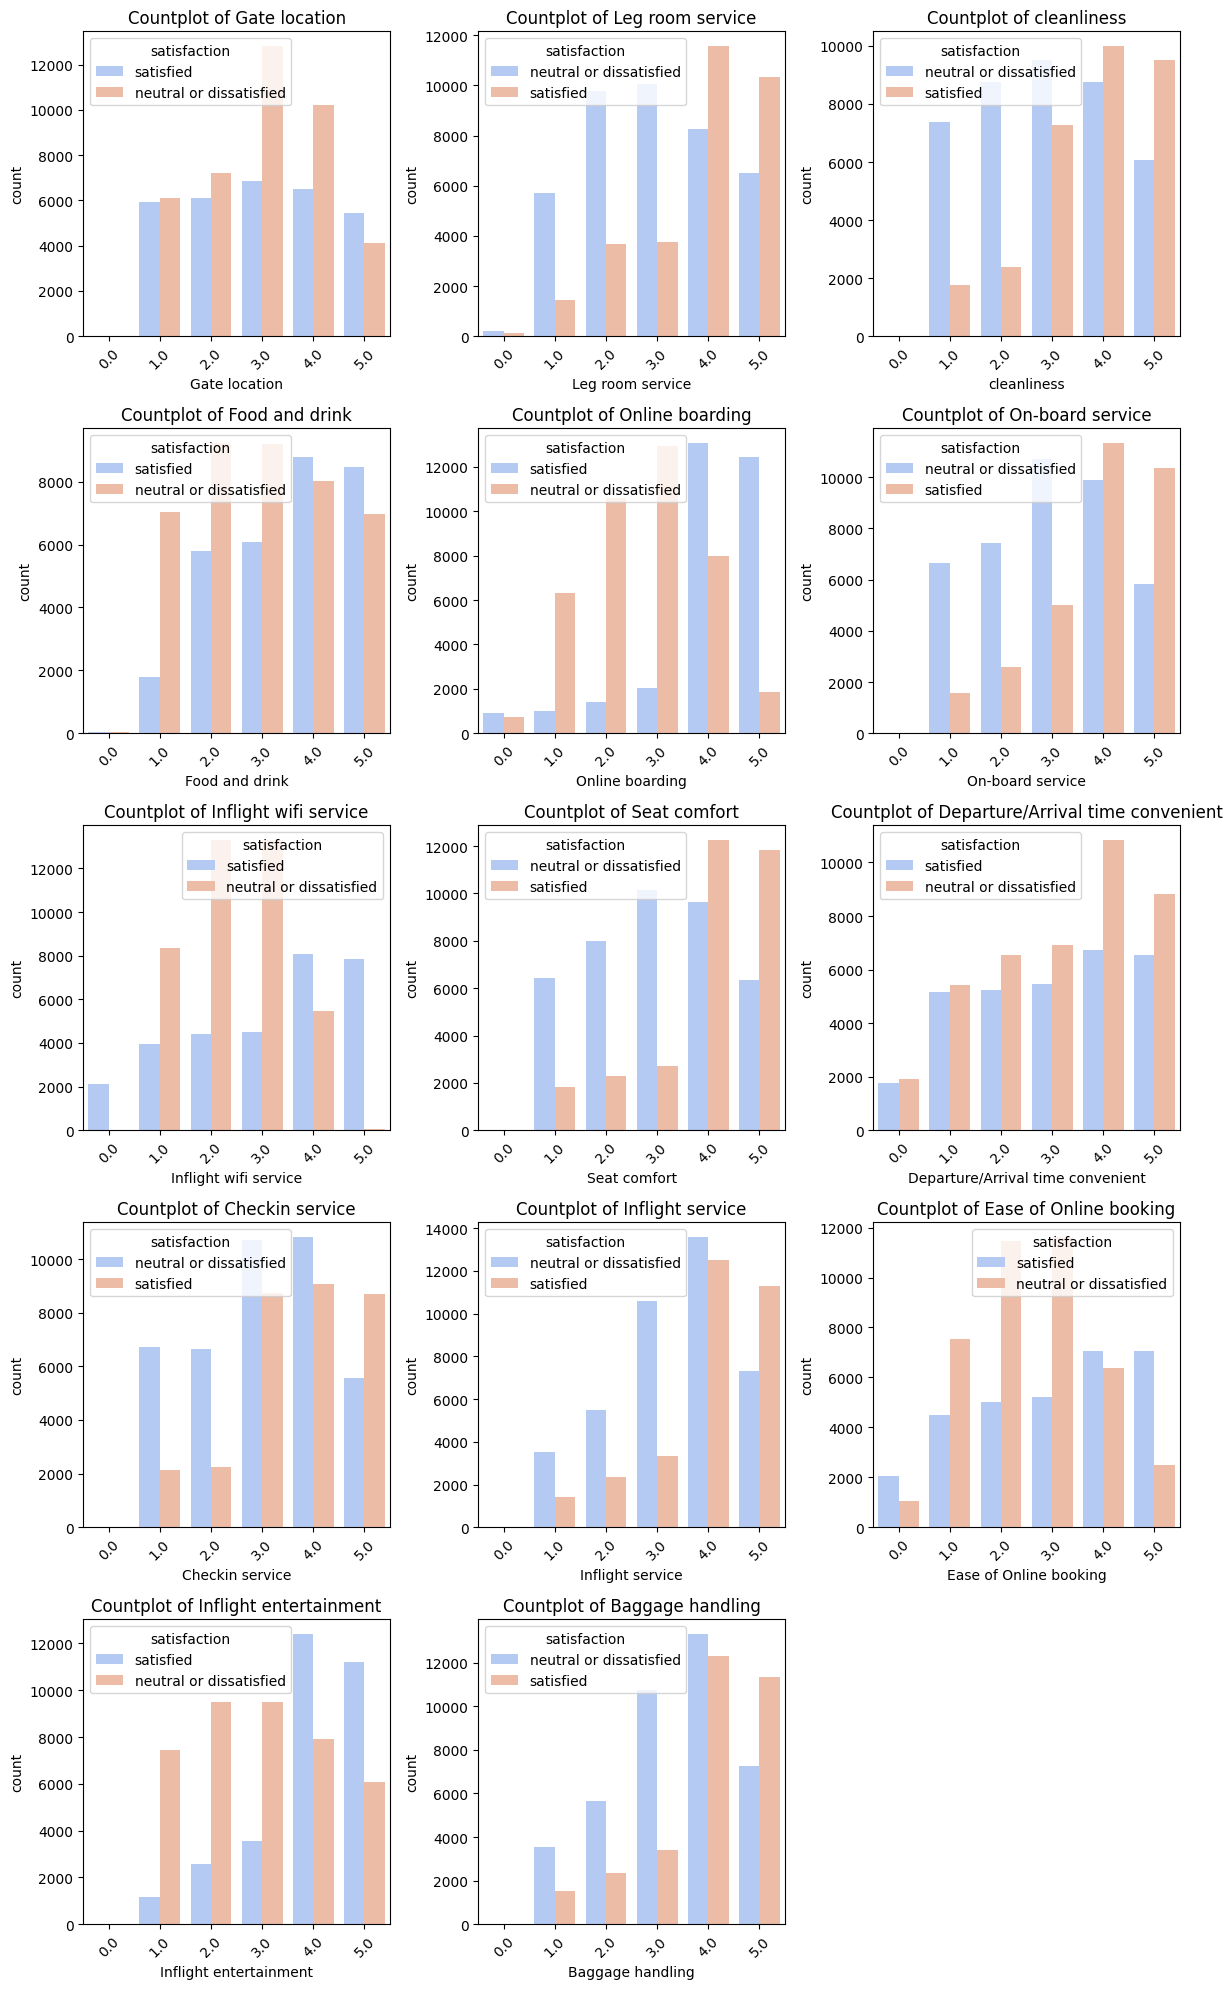

In [40]:
plot_ordinal(ordinal_cols, X_train, y_train)

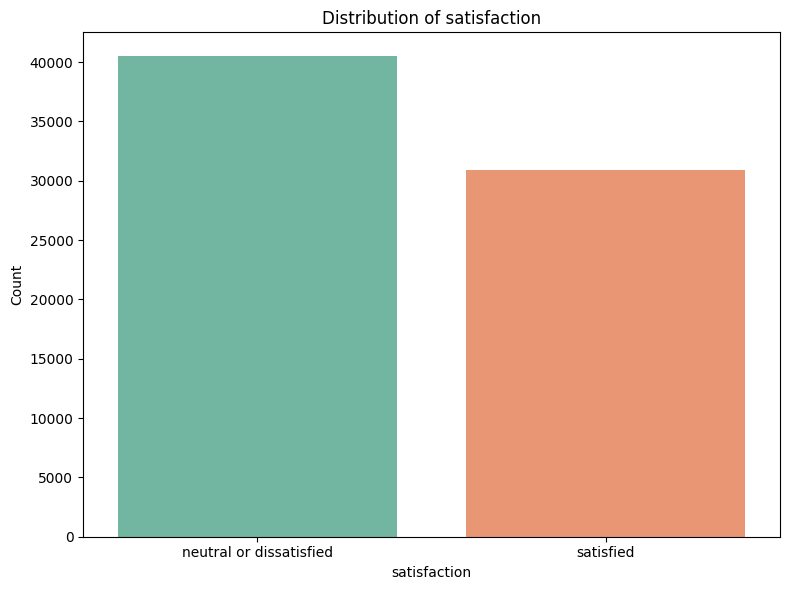

In [41]:
# visualize y_train
plot_target_distribution(y_train, 'satisfaction')

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки


```
* 'Customer Type', 'Type of Travel', 'class' - распределены не равномерно
* классы не сбалансированы
* age - похоже на нормальное распределение; остальные на логнормальное; нужно делать тесты на соответствие;
```



### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

```
1) сравним распределения категориальных признаков
```

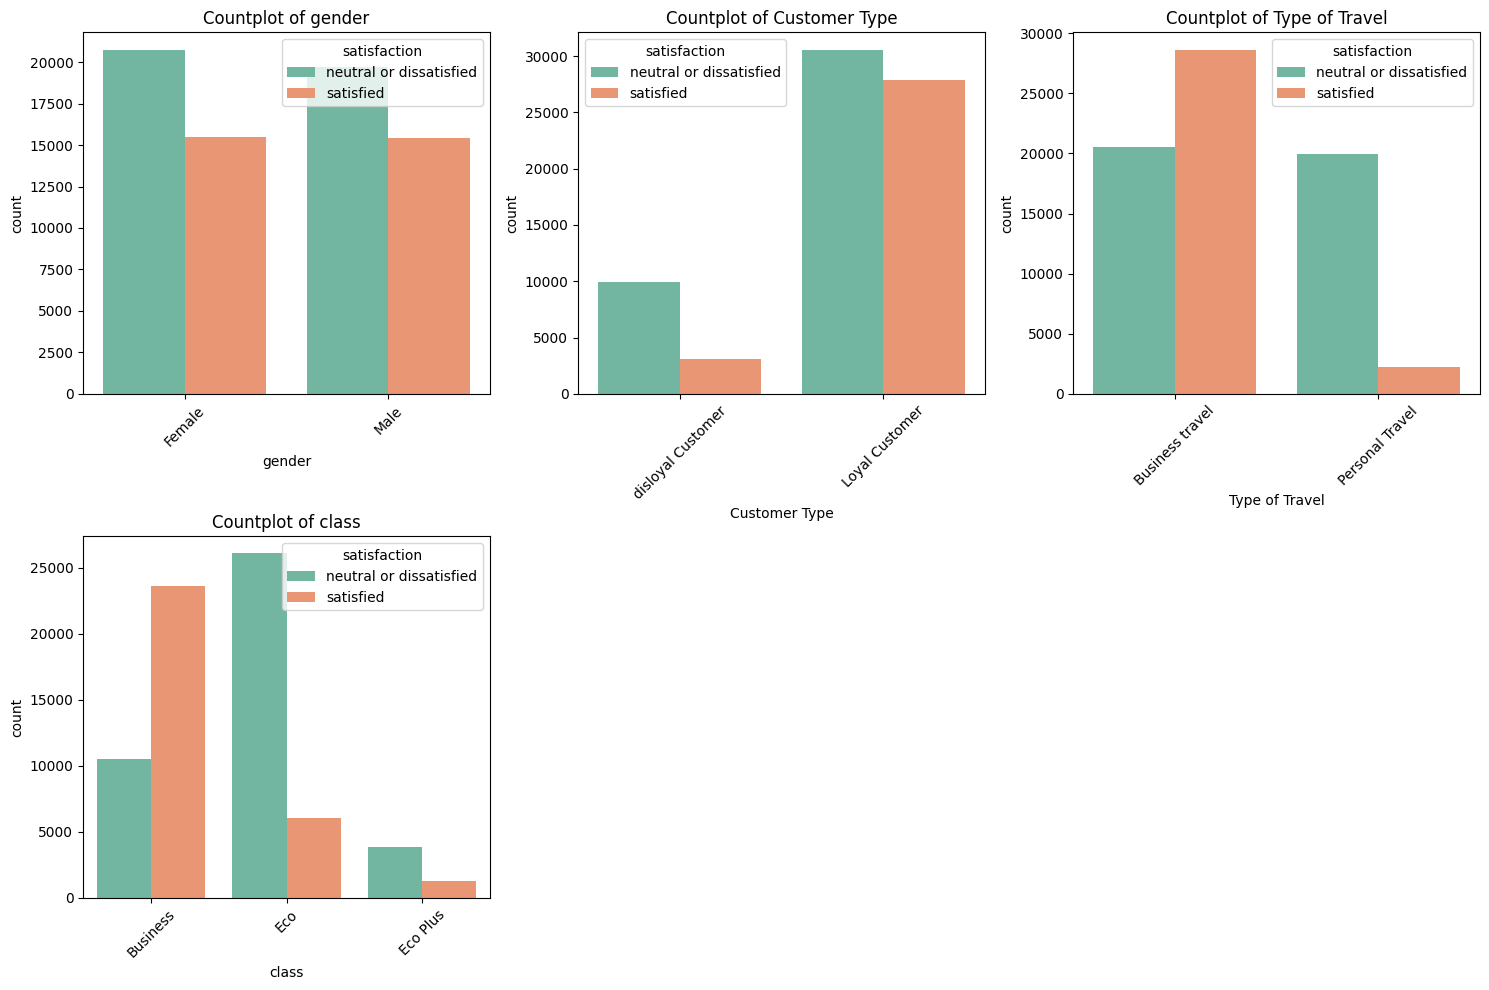

In [42]:
# train
plot_categorical(categorical_cols, X_train, y_train)

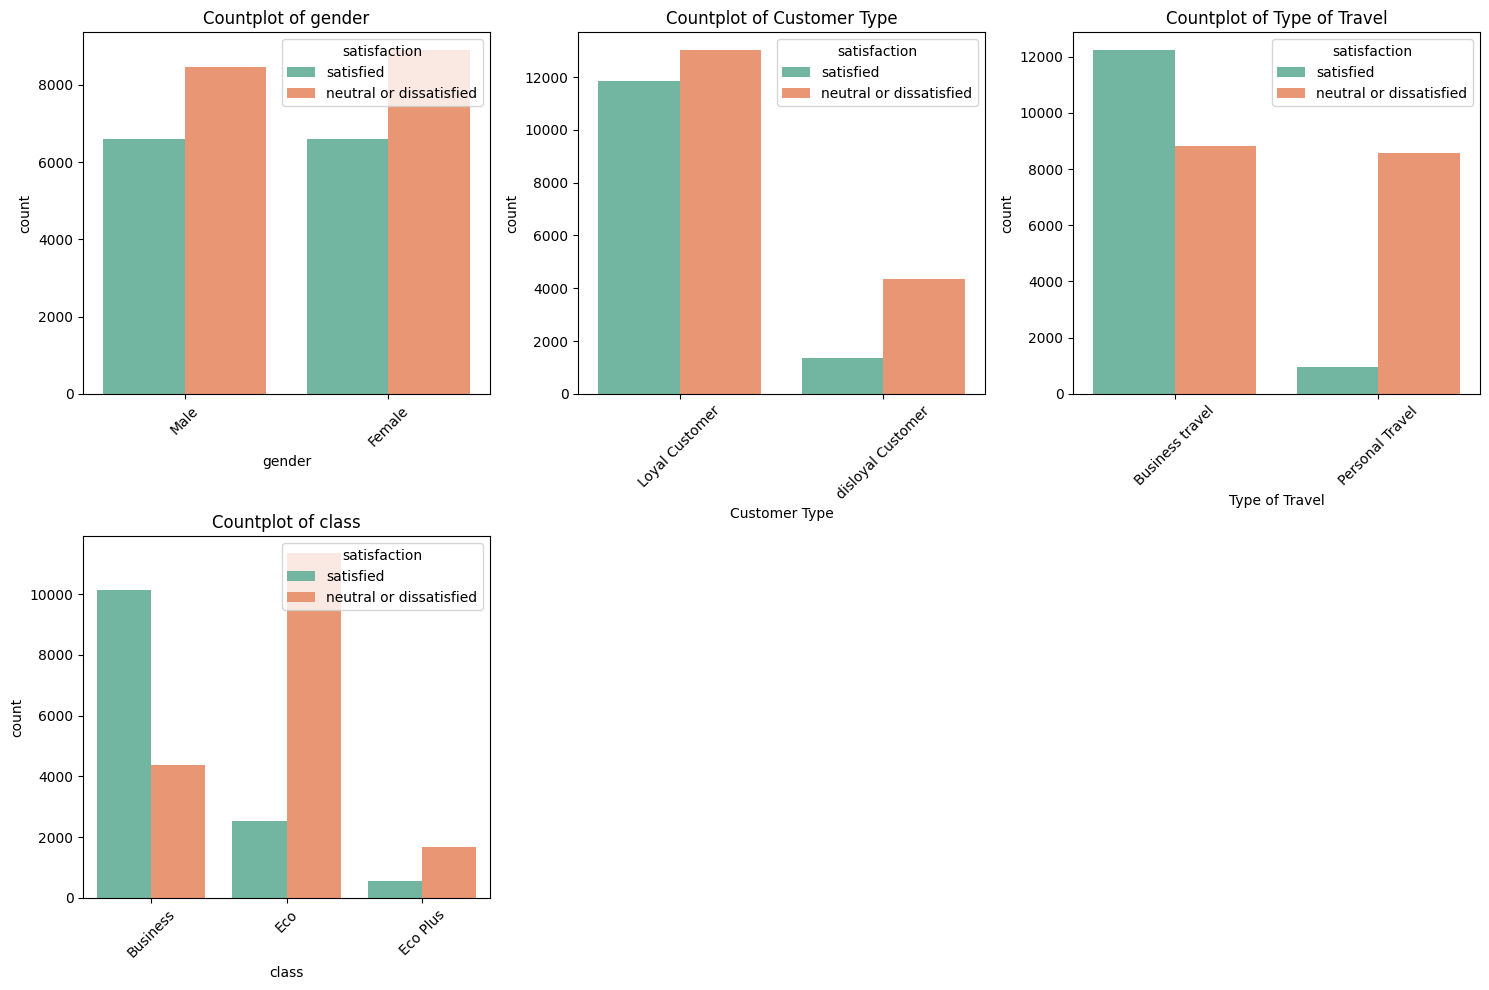

In [43]:
# validate
plot_categorical(categorical_cols, X_val, y_val)

```
Распределения категориальных признаков выглядят похожими для train и validate
```

```
2) сравним порядковые признаки
```

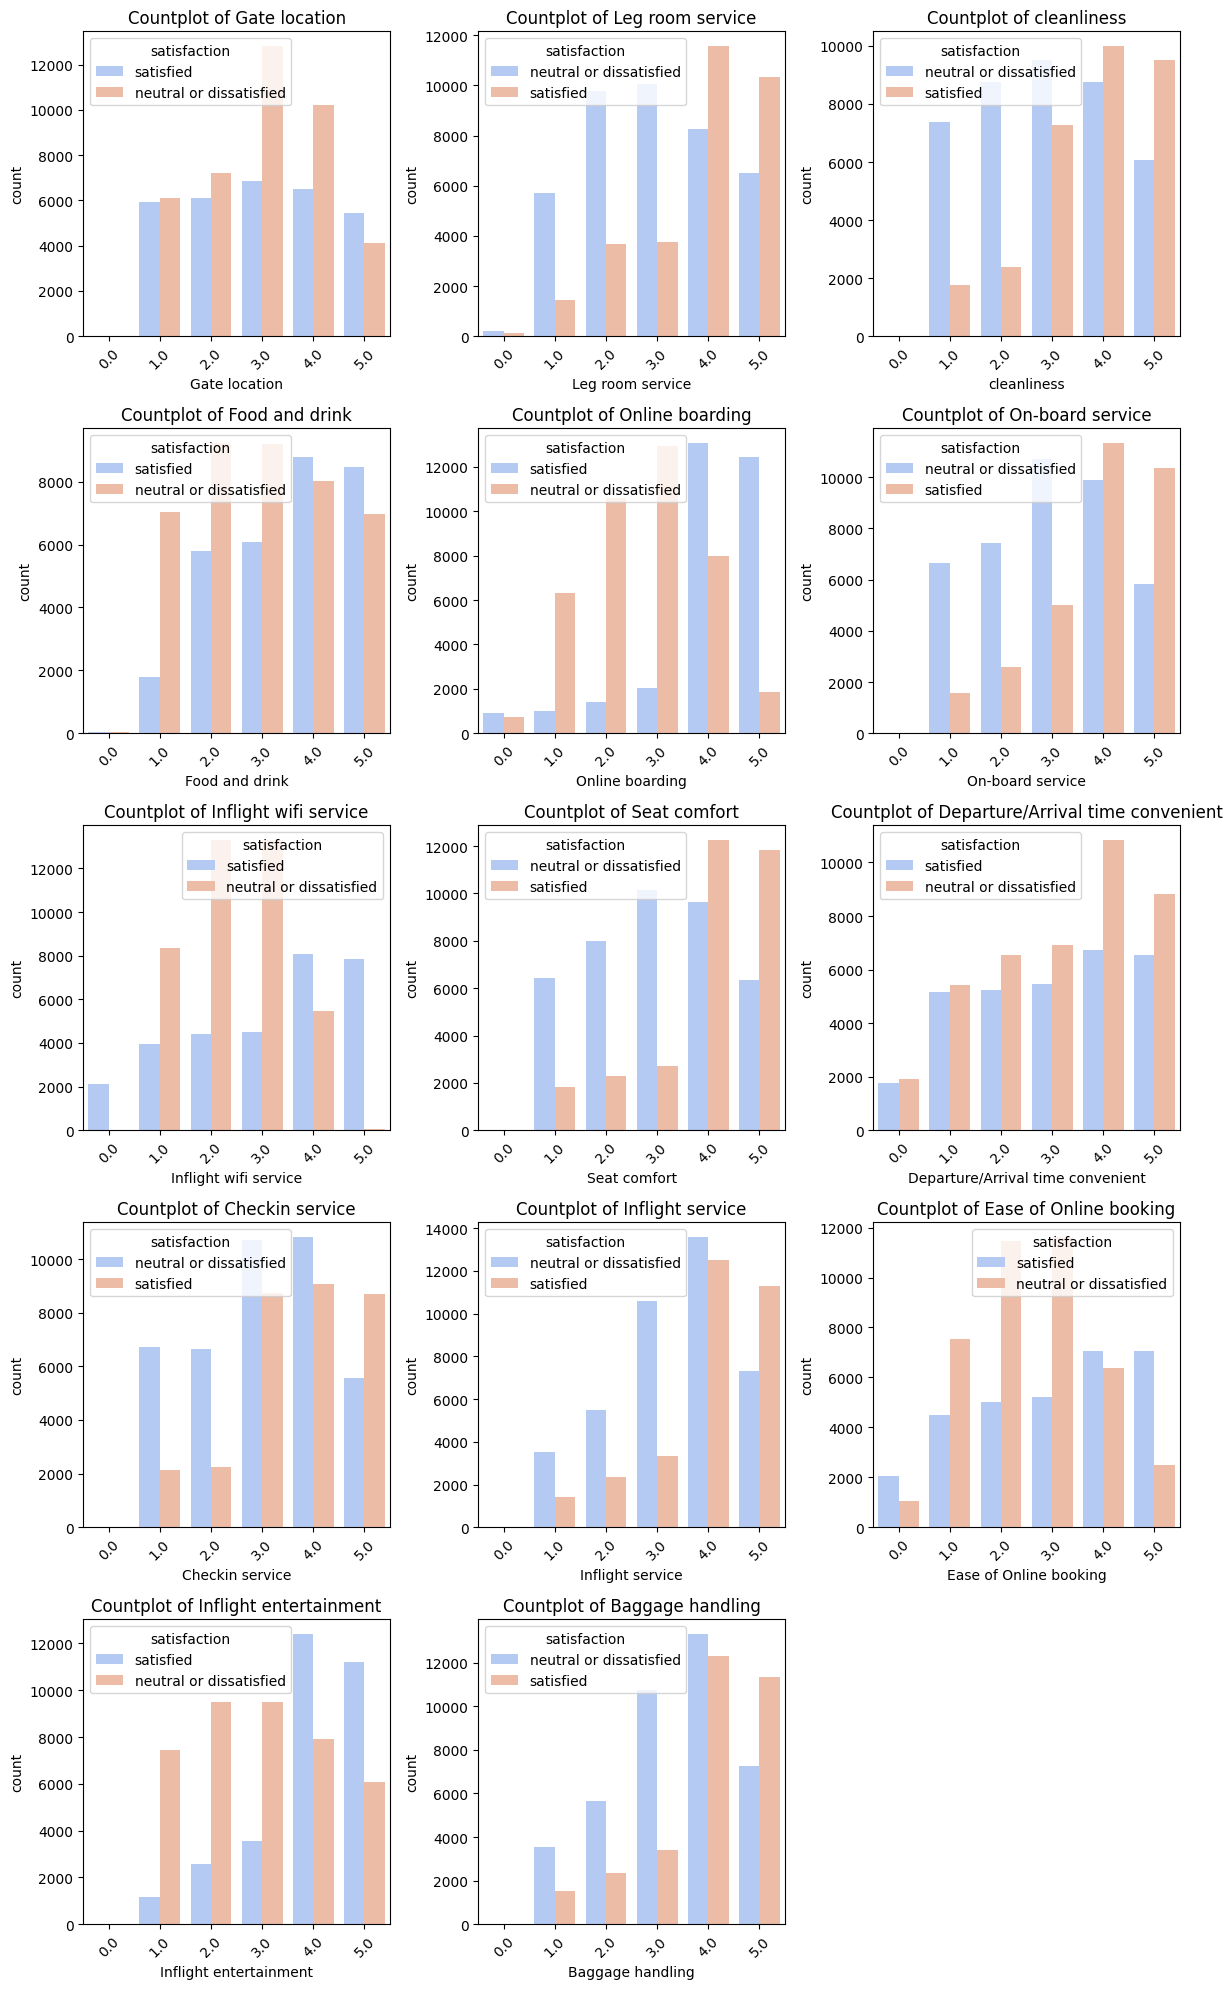

In [44]:
# train
plot_ordinal(ordinal_cols, X_train, y_train)

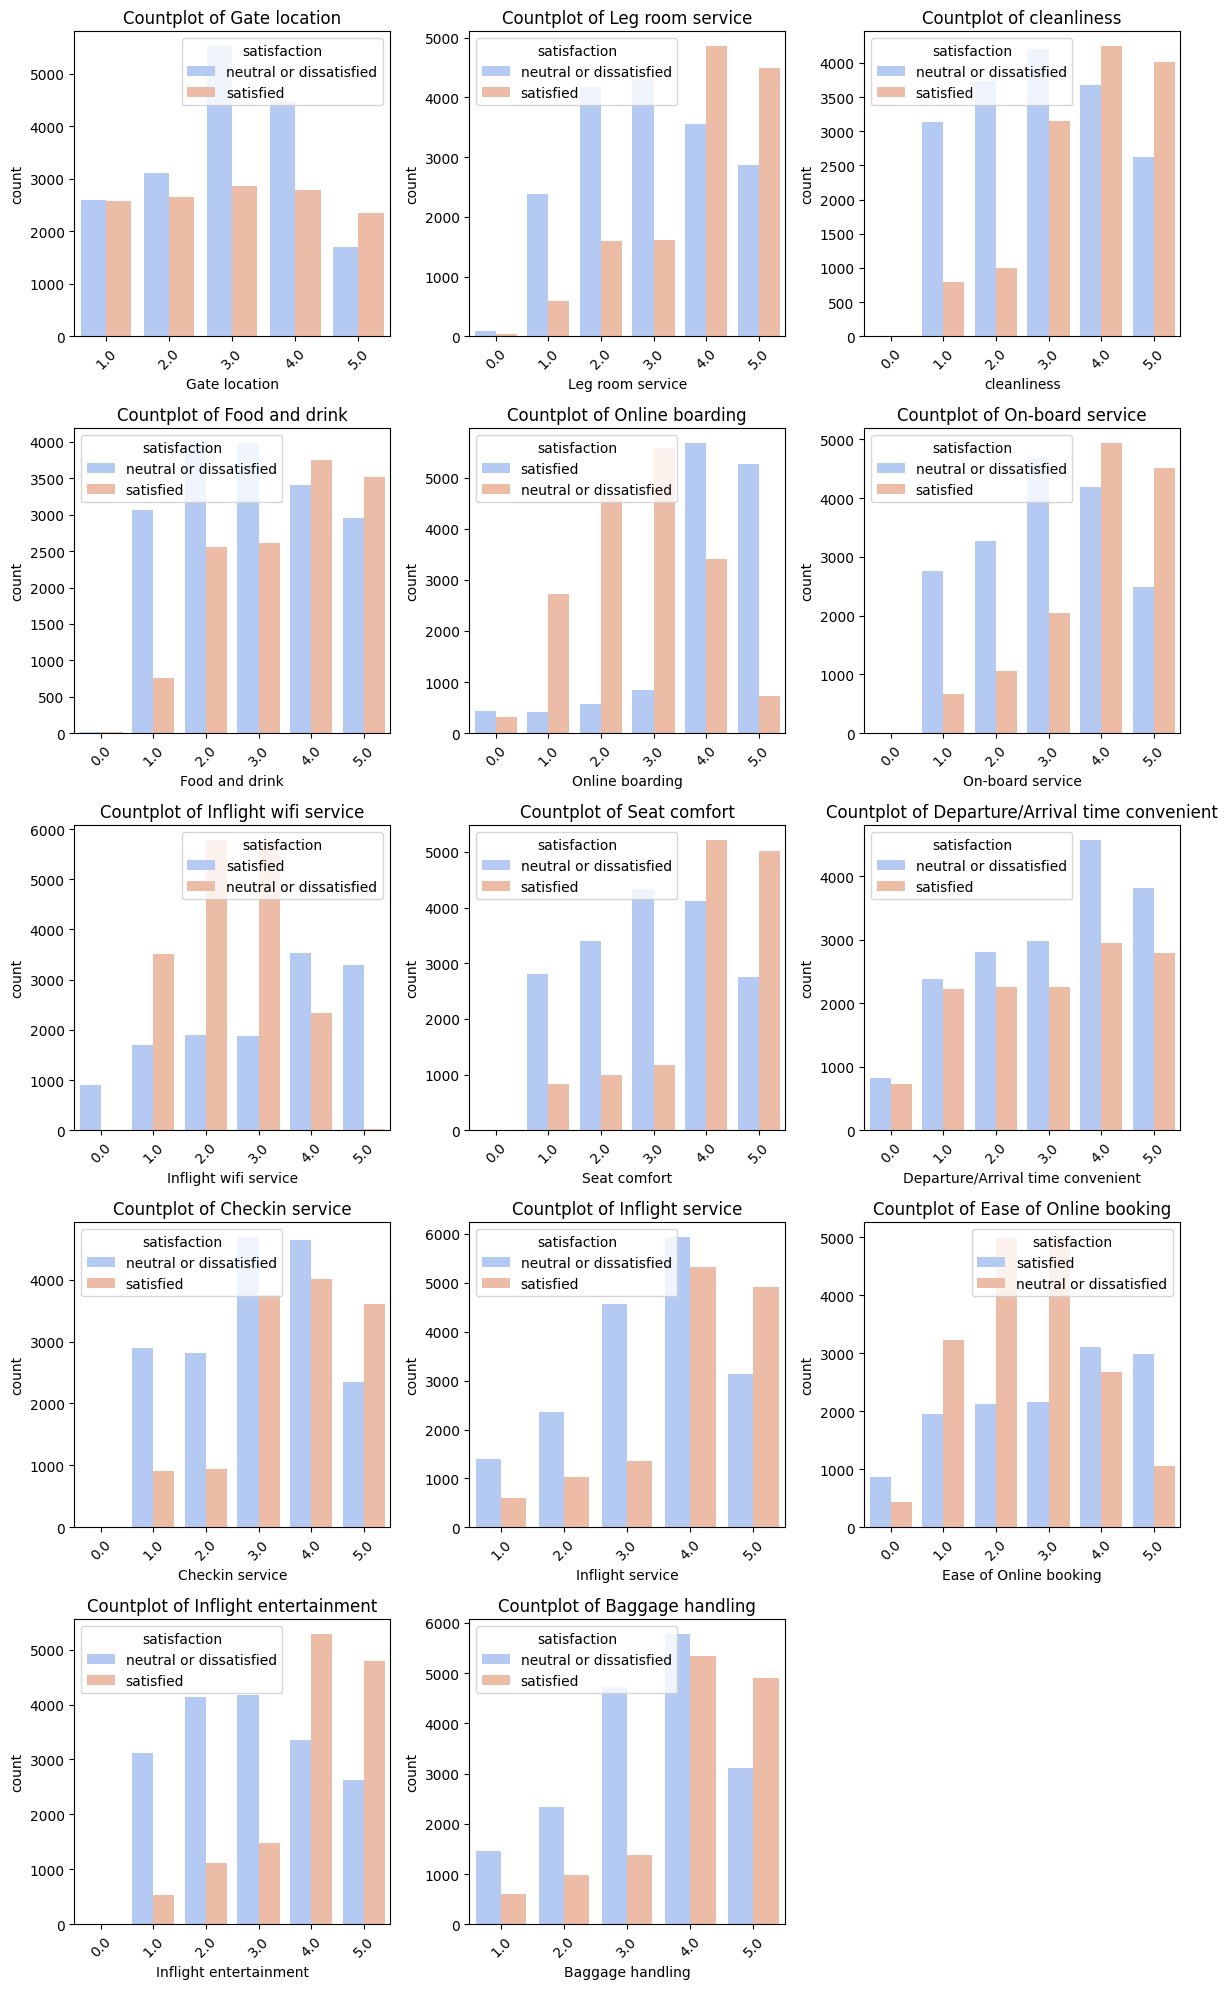

In [45]:
# validate
plot_ordinal(ordinal_cols, X_val, y_val)

```
Распределения порядковых признаков выглядят похожими для train и validate
```

```
3) сравним числовые (непрерывные) признаки
```


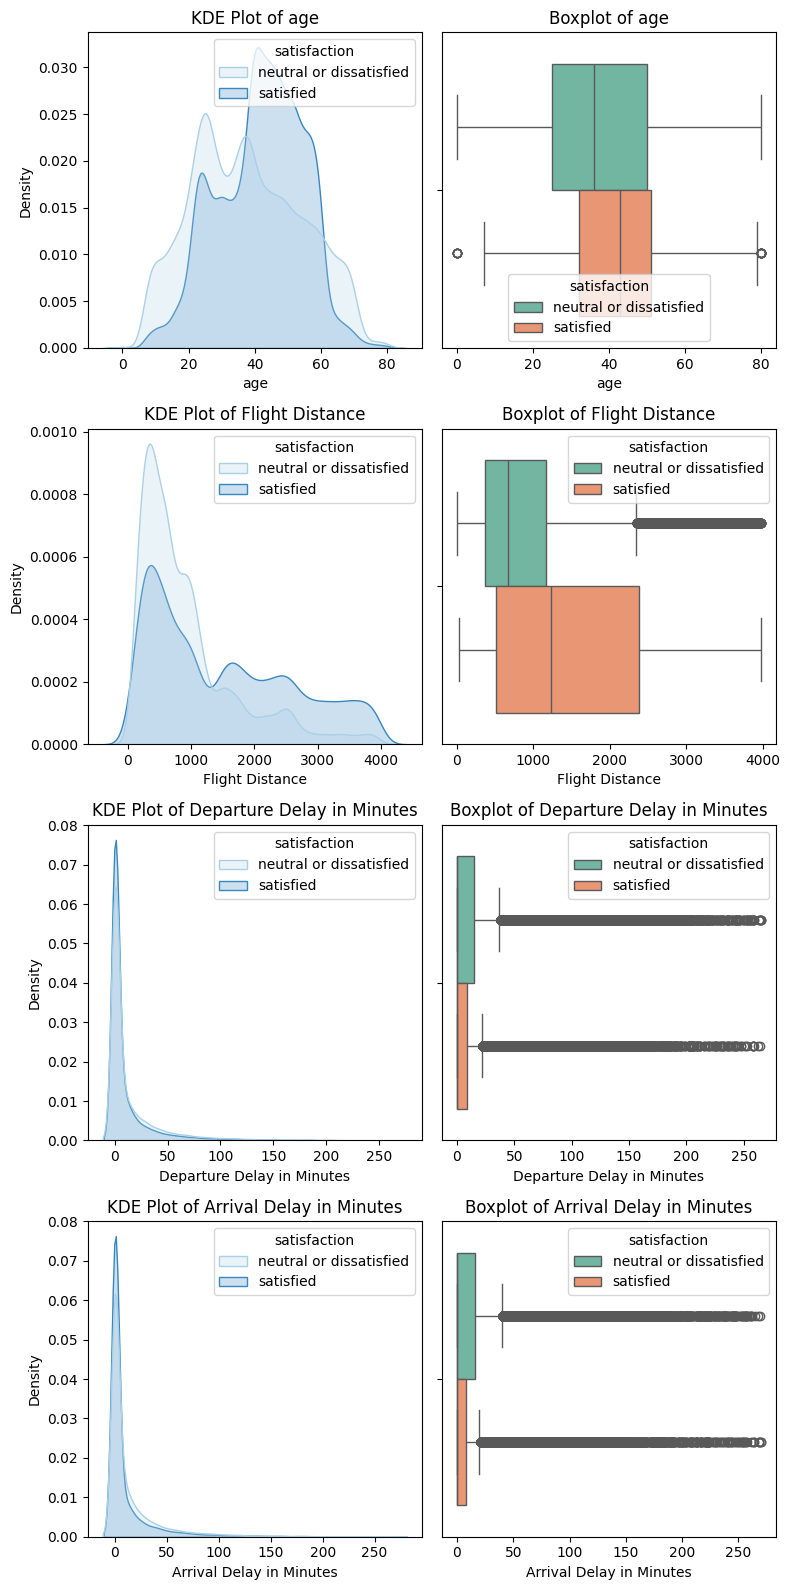

In [46]:
# train
plot_continuous(continuous_cols, X_train, y_train)

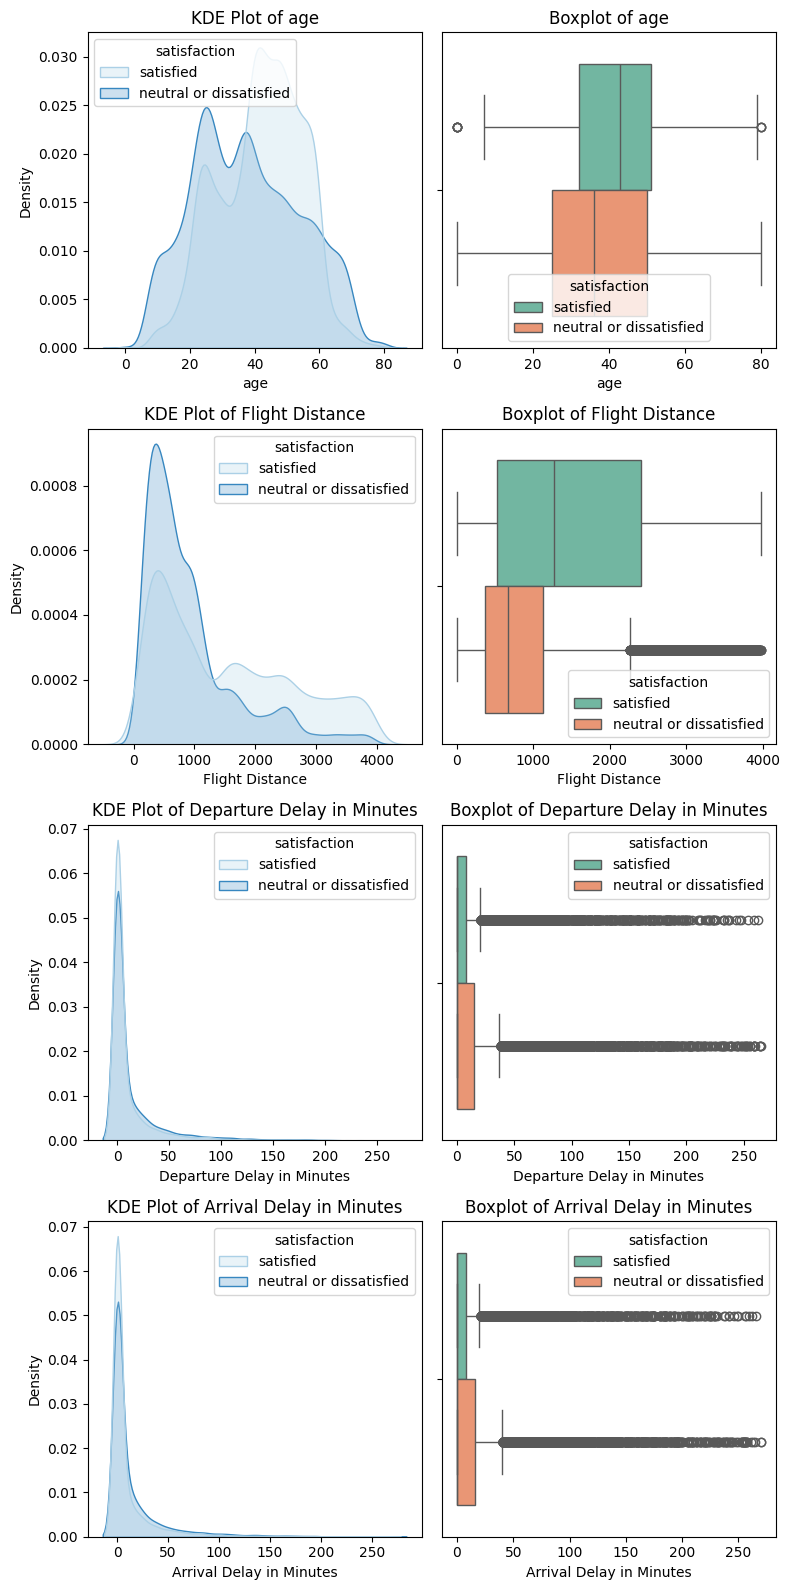

In [47]:
# validate
plot_continuous(continuous_cols, X_val, y_val)

```
Распределения непрерывных признаков выглядят похожими для train и validate
```

### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [48]:
X_train['Departure Delay in Minutes'] = np.log1p(X_train['Departure Delay in Minutes'])
X_train['Arrival Delay in Minutes'] = np.log1p(X_train['Arrival Delay in Minutes'])

In [49]:
X_val['Departure Delay in Minutes'] = np.log1p(X_val['Departure Delay in Minutes'])
X_val['Arrival Delay in Minutes'] = np.log1p(X_val['Arrival Delay in Minutes'])

Построение.

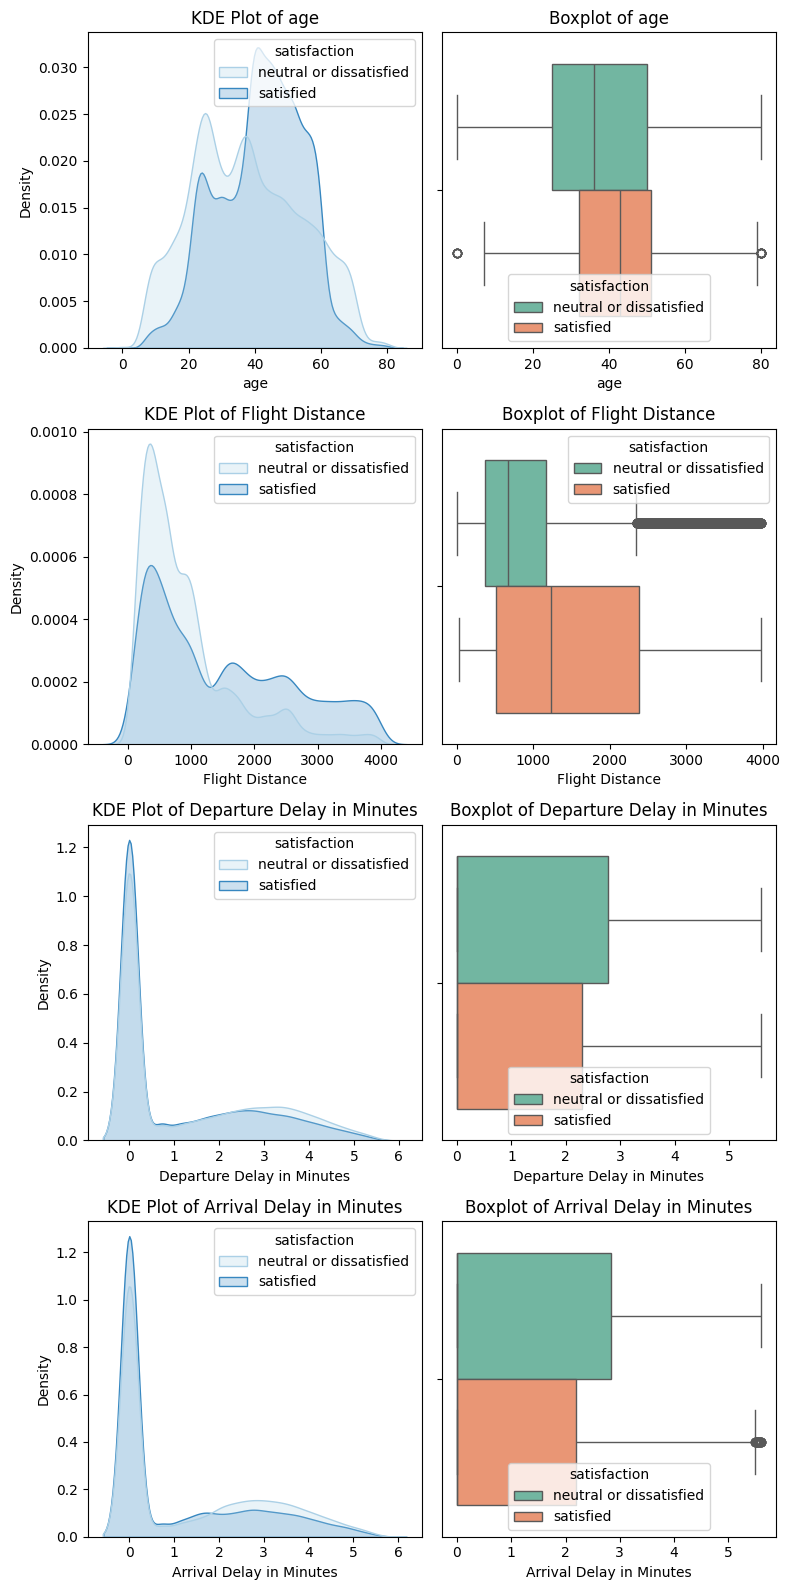

In [50]:
plot_continuous(continuous_cols, X_train, y_train)

```
Логарифмирование сильно изменило распределение, уменьшило влияние выбросов
```

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

In [51]:
def plot_pairwise_continuous(cols, df, y):
    df_copy = df[cols].copy()
    df_copy['target'] = y
    sns.pairplot(df_copy, hue='target', palette='Set2')
    plt.show()

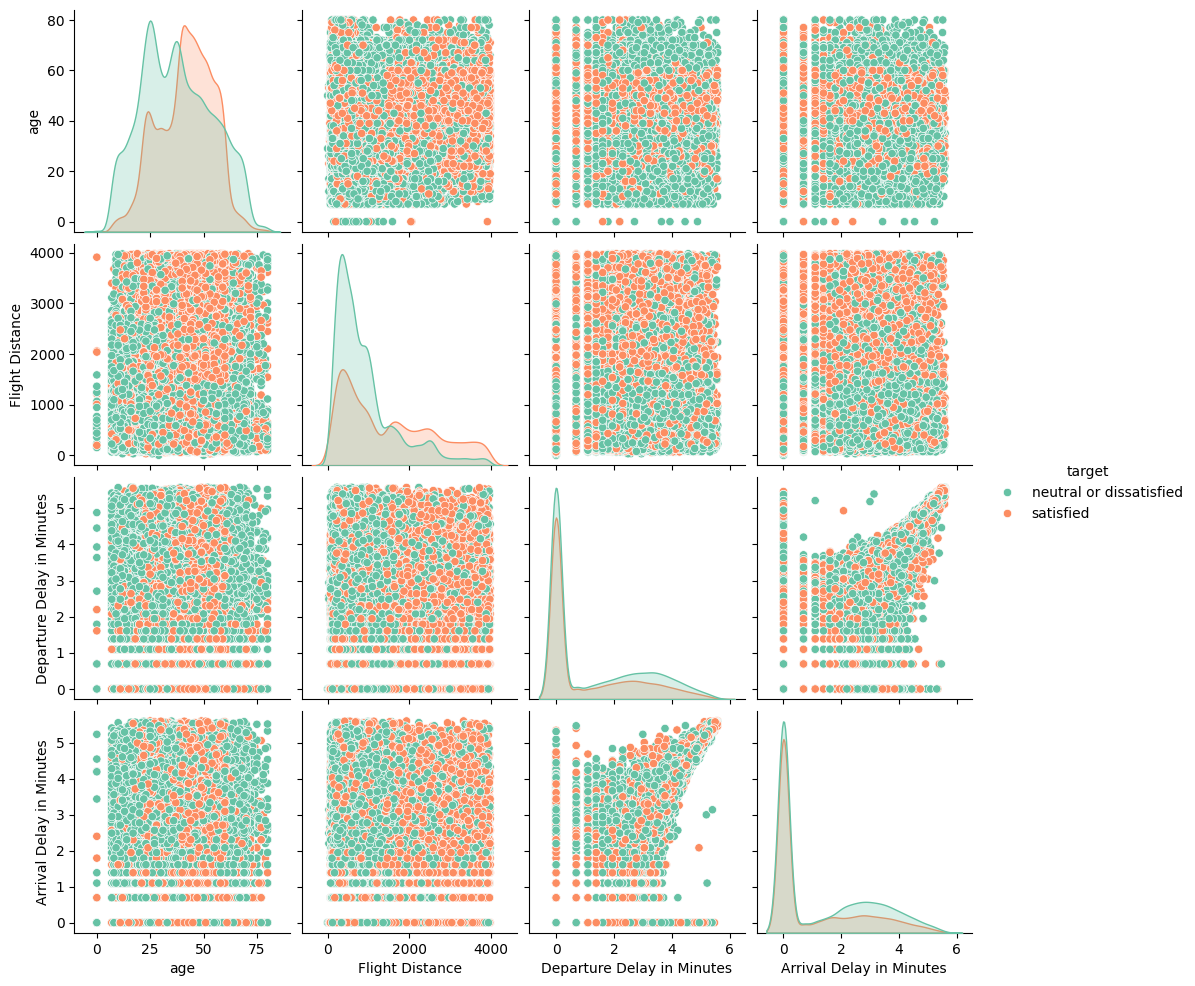

In [52]:
plot_pairwise_continuous(continuous_cols, X_train, y_train)

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

```
Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
```

In [53]:
y_train = y_train.map({'satisfied': 1}).fillna(0).astype(int)
y_val = y_val.map({'satisfied': 1}).fillna(0).astype(int)

```
Закодируйте категориальные признаки методом OHE;
```

In [54]:
categorical_cols

['gender', 'Customer Type', 'Type of Travel', 'class']

```
Напишем кастомный sklearn трансформер, тк мы хотим сохранять структуру датасета pd.DataFrame,
sklearn.preprocessing.OneHotEncoder этого не позволяет

переиспользовал код https://stackoverflow.com/a/70000745
```

In [55]:
from sklearn.base import BaseEstimator, TransformerMixin

class GetDummies(BaseEstimator, TransformerMixin):
    def __init__(self, dummy_columns):
        self.columns = None
        self.dummy_columns = dummy_columns

    def fit(self, X, y=None):
        self.columns = pd.get_dummies(X, columns=self.dummy_columns).columns
        return self

    def transform(self, X):
        X_new = pd.get_dummies(X, columns=self.dummy_columns, drop_first=True, dtype='float')
        return X_new.reindex(columns=self.columns, fill_value=0)

In [56]:
ohe = GetDummies(dummy_columns=categorical_cols)
ohe.fit(X_train)
X_train_enc = ohe.transform(X_train)
X_val_enc = ohe.transform(X_val)

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [57]:
model_decision_tree_classifier_1 = DecisionTreeClassifier(random_state=42)
model_decision_tree_classifier_1.fit(X_train_enc, y_train)

DecisionTreeClassifier(random_state=42)

In [58]:
y_predicted_val_model_decision_tree_classifier_1 = model_decision_tree_classifier_1.predict(X_val_enc)
accuracy_score(y_val, y_predicted_val_model_decision_tree_classifier_1)

0.9411111111111111

## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [59]:
error_dt, bias_dt, var_dt = bias_variance_decomp(model_decision_tree_classifier_1,
                                                 X_train_enc.values,
                                                 y_train.values,
                                                 X_val_enc.values,
                                                 y_val.values,
                                                 loss='0-1_loss')
error_dt, bias_dt, var_dt

(0.06166470588235295, 0.04055555555555555, 0.04592058823529412)

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [60]:
# depth
model_decision_tree_classifier_1.get_depth()

29

In [61]:
# leaves
model_decision_tree_classifier_1.get_n_leaves()

2070

### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

In [62]:
def plot_feature_importances(cols, feature_importances):
    importance_df = pd.DataFrame(
        {'Feature': cols, 'Importance': feature_importances}
    )

    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', legend=False)
    plt.title('Feature Importance')
    plt.show()

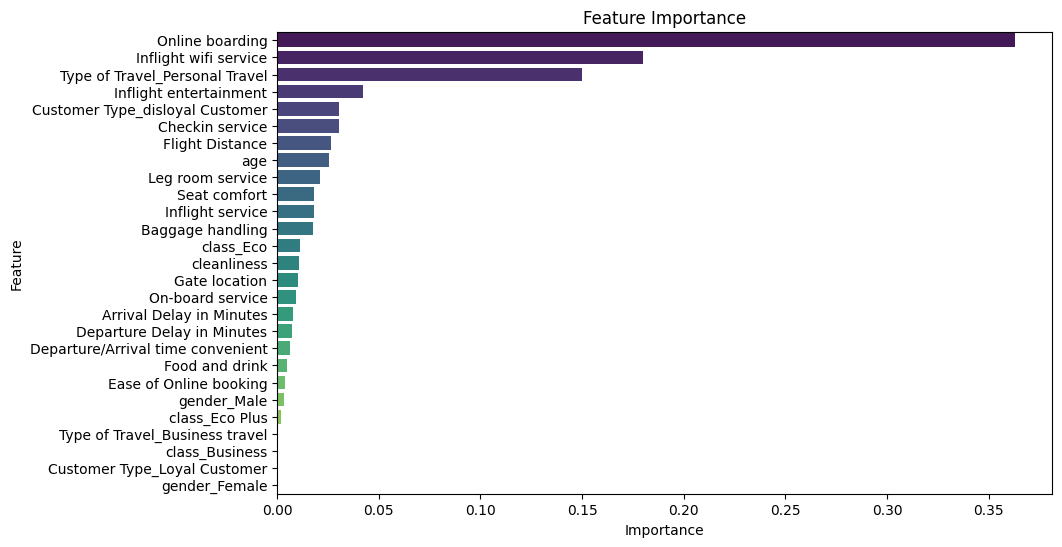

In [63]:
plot_feature_importances(list(X_train_enc.columns), model_decision_tree_classifier_1.feature_importances_)

```
Наиболее информативными признаками оказались:
* Online boarding
* Inflight wifi service
* Type of Travel_Personal Travel
```

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [64]:
X_train_2_features = X_train[['Online boarding', 'Inflight wifi service']]
X_val_2_features = X_val[['Online boarding', 'Inflight wifi service']]

In [65]:
model_decision_tree_classifier_2 = DecisionTreeClassifier(max_depth=5)
model_decision_tree_classifier_2.fit(X_train_2_features, y_train)

DecisionTreeClassifier(max_depth=5)

In [66]:
y_predicted_val_model_decision_tree_classifier_2 = model_decision_tree_classifier_2.predict(X_val_2_features)
accuracy_score(y_val, y_predicted_val_model_decision_tree_classifier_2)

0.8248366013071895

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

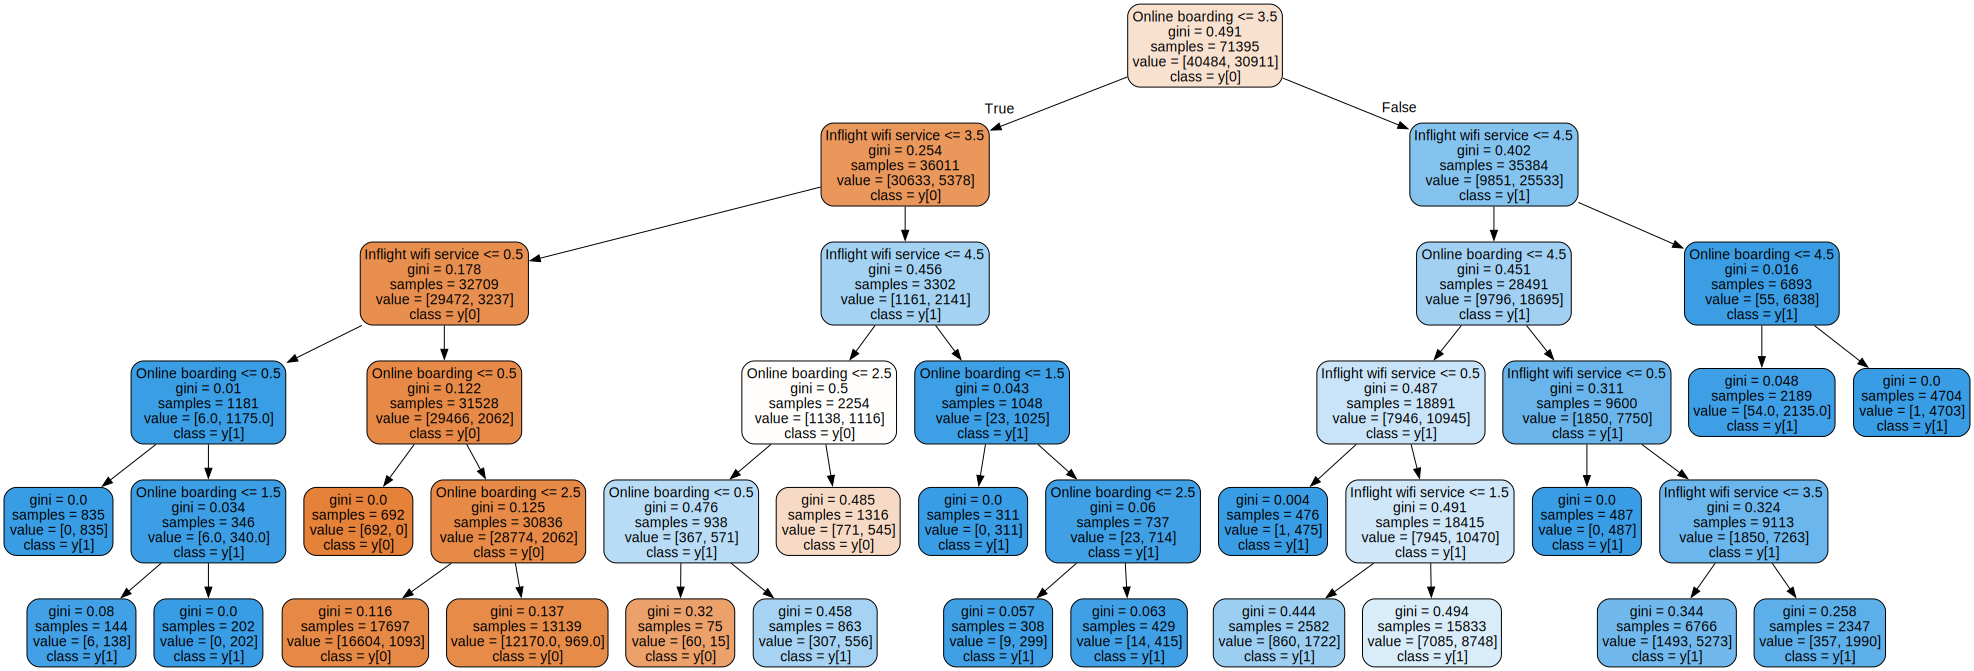

In [67]:
dot_data = export_graphviz(model_decision_tree_classifier_2, out_file=None,
                           feature_names=list(X_train_2_features.columns),
                           class_names=True,
                           filled=True, rounded=True)
Source(dot_data)

In [68]:
X_train_2_features['Inflight wifi service'].unique()


array([2., 0., 3., 4., 5., 1.])

In [69]:
X_train_2_features['Online boarding'].unique()

array([2., 3., 5., 4., 1., 0.])

Предикаты получились кратны 1/2, возможно, для более точного разбиения. Признаки порядковые, представлены в виде числа. Если в реальных данных встретятся дробные значения, например оценка Online boarding = 2.7, то модель будет работать более точно.
Хотя с другой стороны мы всегда предполагаем, что тренировочные данные имеют то же распределение, что и реальные :\

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

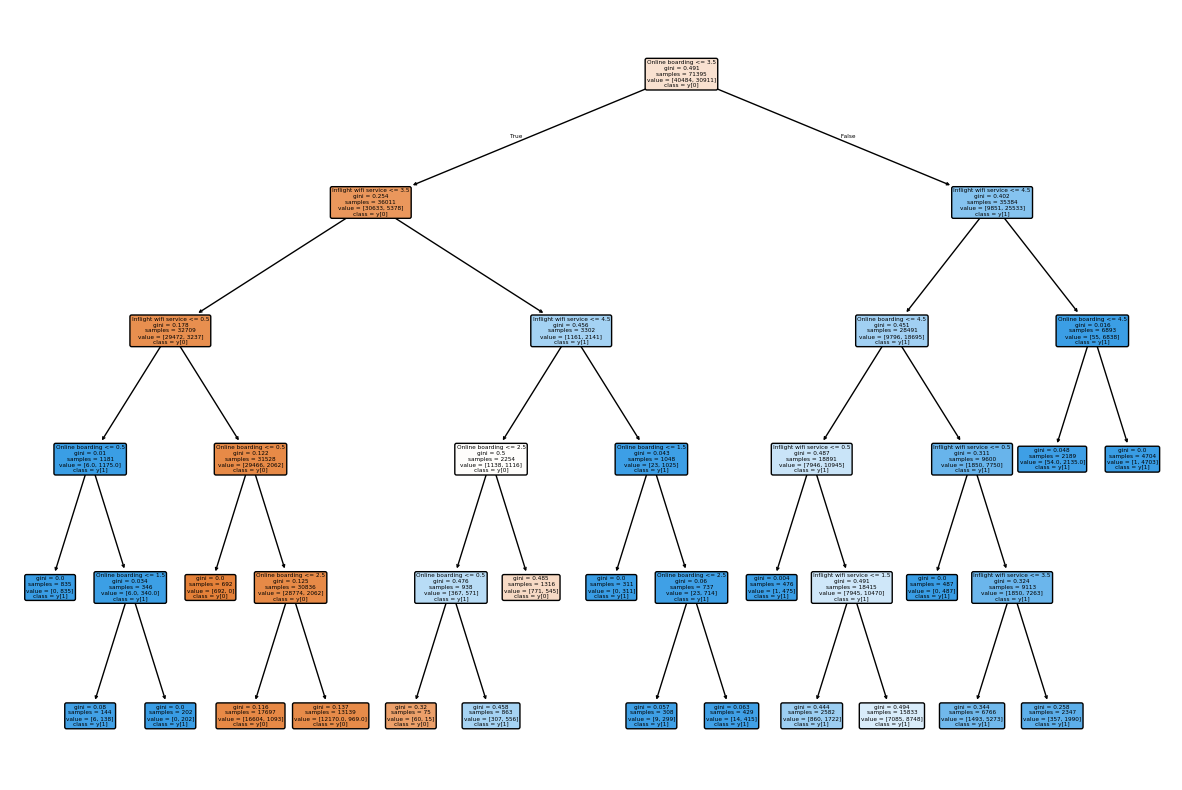

In [70]:
plt.figure(figsize=(15, 10))
plot_tree(model_decision_tree_classifier_2, feature_names=list(X_train_2_features.columns), class_names=True, filled=True, rounded=True)
plt.show()

```
Дерево получилось не точно зеркально симметричным (скорее всего из-за дисбаланса классов), но выглядит достаточно сбалансированным. Вообще решающее дерево симметричной структуры имеет бОльшую обобщаю способность
```

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

In [71]:
def custom_plot_decision_regions(model, X, y, xlabel, ylabel, title):
    plt.figure(figsize=(10, 6))
    plot_decision_regions(X=X, y=y, clf=model, legend=2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

/Users/denis.bobylev/Documents/hse/ml-hw/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


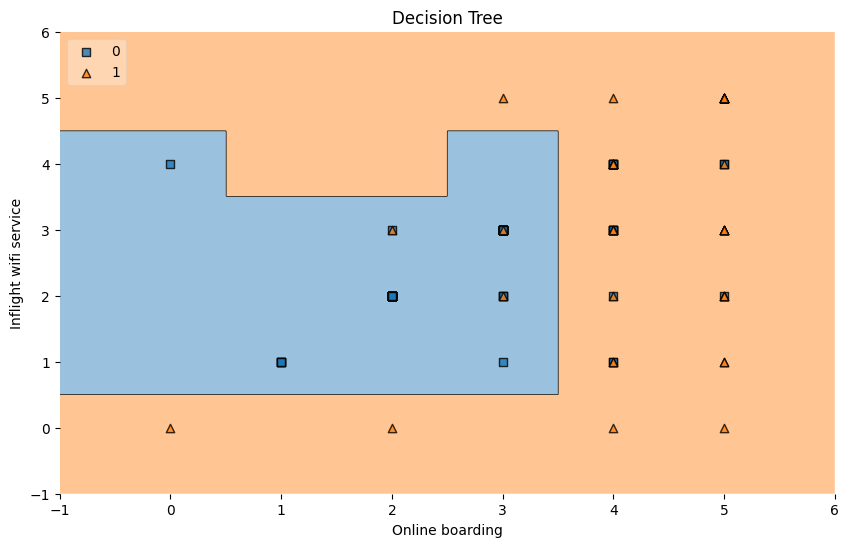

In [72]:
X_train_2_features_100 = X_train_2_features[:100]
y_train_2_features_100 = y_train[:100]
custom_plot_decision_regions(model=model_decision_tree_classifier_2,
                            X=X_train_2_features_100.values,
                            y=y_train_2_features_100.values,
                            xlabel='Online boarding',
                            ylabel='Inflight wifi service',
                            title='Decision Tree'
                            )

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

/Users/denis.bobylev/Documents/hse/ml-hw/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/denis.bobylev/Documents/hse/ml-hw/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/denis.bobylev/Documents/hse/ml-hw/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/denis.bobylev/Documents/hse/ml-hw/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/denis.bobylev/Documents/hse/ml-hw/venv/lib/python3.12/site-pa

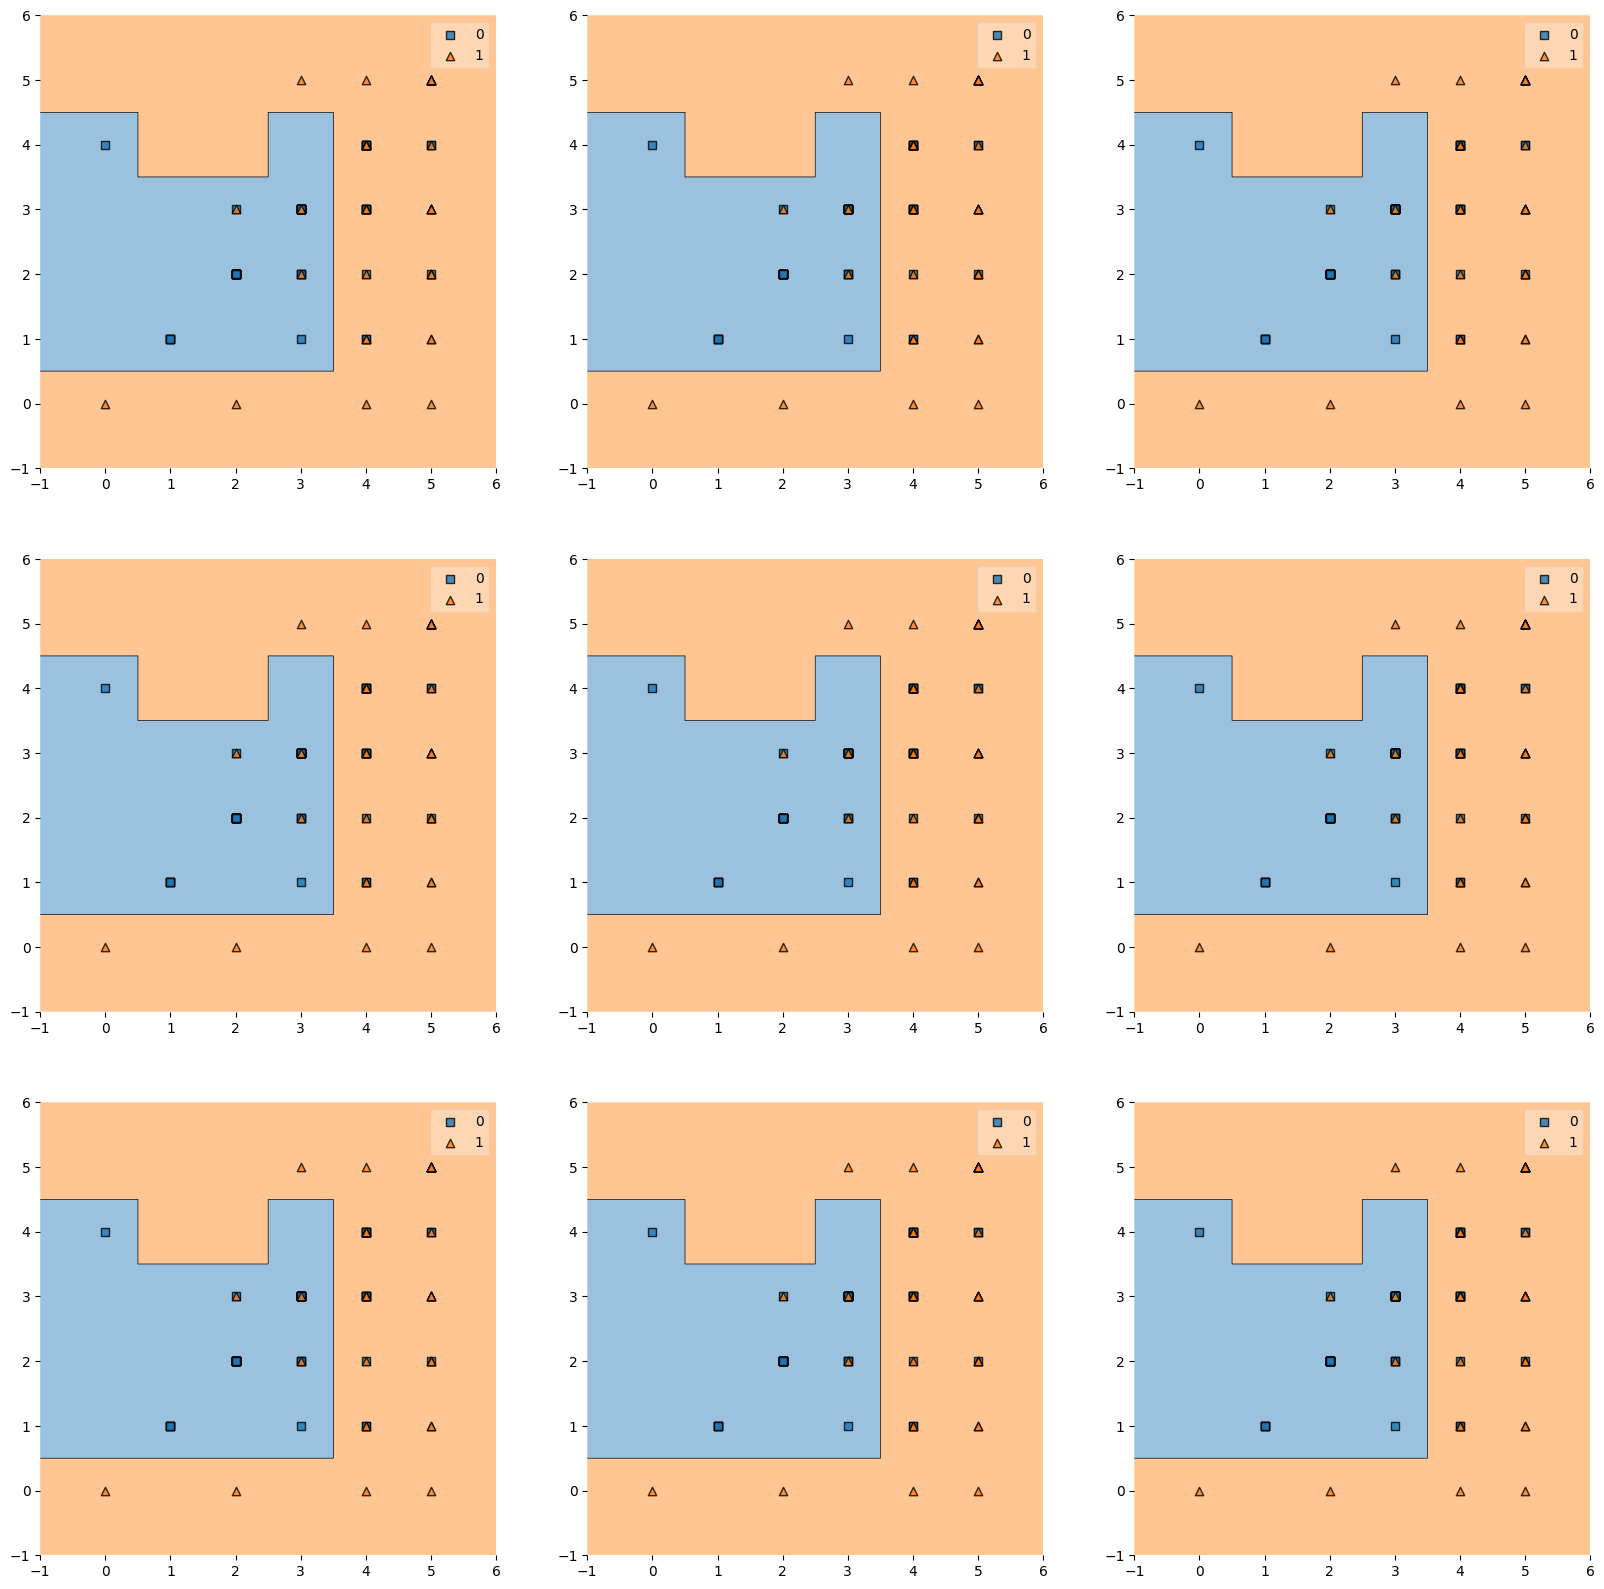

In [73]:
# замените X_train_example на вашу переменную

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_2_features.index, size=X_train_2_features.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность
        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_2_features.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_2_features.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])
plt.show()

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [74]:
# замените X_train_example на вашу переменную (ohe-encoded)

# %%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

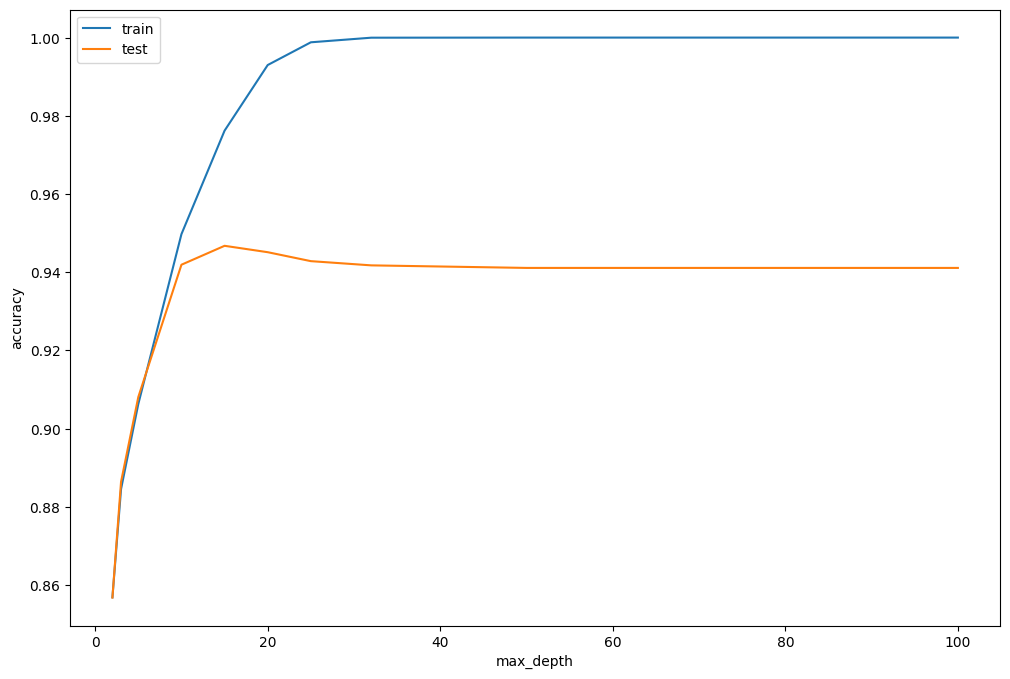

In [75]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [76]:
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 5, 10, 20],
    'criterion': ['gini', 'entropy'],
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_enc, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 15, 20]})

In [77]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 10}

In [78]:
model_decision_tree_classifier_best = grid_search.best_estimator_

In [79]:
y_predicted_val_model_decision_tree_classifier_best = model_decision_tree_classifier_best.predict(X_val_enc)
accuracy_score(y_val, y_predicted_val_model_decision_tree_classifier_best)

0.9515359477124183

```
Удалось незначительно улучшить качество модели
```

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [80]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(model_decision_tree_classifier_best, f)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [81]:
model_random_forest_classifier_1 = RandomForestClassifier(random_state=42)
model_random_forest_classifier_1.fit(X_train_enc, y_train)

RandomForestClassifier(random_state=42)

In [82]:
y_predicted_val_model_random_forest_classifier_1 = model_random_forest_classifier_1.predict(X_val_enc)
accuracy_score(y_val, y_predicted_val_model_random_forest_classifier_1)

0.9612418300653595

### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

In [83]:
from sklearn.calibration import calibration_curve


def plot_calibration_curve(y_prob, y, model_name):
    fraction_of_positives, mean_predicted_value = calibration_curve(y, y_prob, n_bins=10)

    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=model_name, color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', label="Perfectly calibrated", color='gray')
    plt.title(f'Calibration curve for {model_name}')
    plt.xlabel('Mean Predicted Value')
    plt.ylabel('Fraction of Positives')
    plt.legend()
    plt.grid(True)
    plt.show()

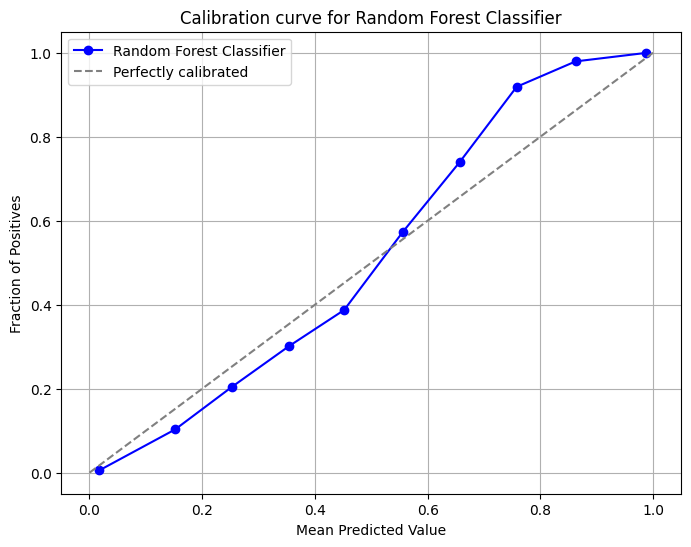

In [84]:
y_prob_model_random_forest_classifier_1 = model_random_forest_classifier_1.predict_proba(X_val_enc)[:, 1]
plot_calibration_curve(y_prob=y_prob_model_random_forest_classifier_1,
                       y=y_val,
                       model_name='Random Forest Classifier')

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?

```
Деревья в целом могут некорректно предсказывать вероятности, потому что дерево делит пространство признаков на блоки (листы), и вероятность для каждого блока является частотой классов в этом листе. Эти вероятности могут быть некорректными, если дерево переобучено
```



### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [85]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_val_scaled = scaler.transform(X_val_enc)

In [86]:
model_logistic_regression_1 = LogisticRegression(random_state=42)
model_logistic_regression_1.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [87]:
y_predicted_val_model_logistic_regression_1 = model_logistic_regression_1.predict(X_val_scaled)
accuracy_score(y_val, y_predicted_val_model_logistic_regression_1)

0.875718954248366

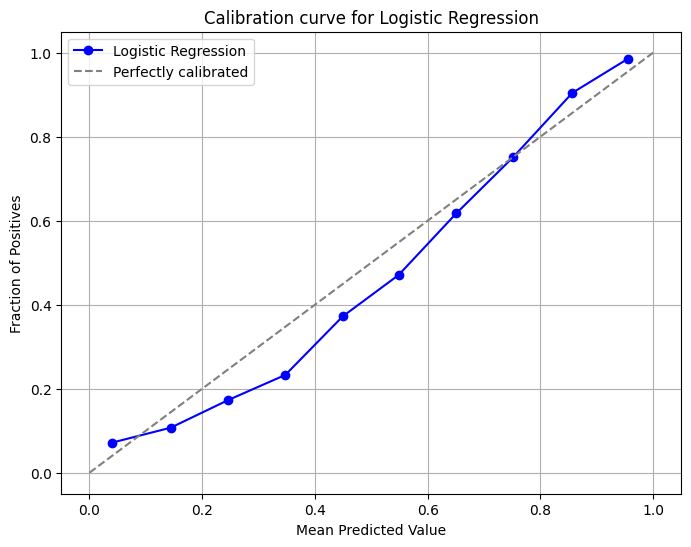

In [88]:
y_prob_model_logistic_regression_1 = model_logistic_regression_1.predict_proba(X_val_scaled)[:, 1]
plot_calibration_curve(y_prob=y_prob_model_logistic_regression_1,
                       y=y_val,
                       model_name='Logistic Regression')

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?



```
Логистическая регрессия обучается путём максимизации правдоподобия
```


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [89]:
y_prob_model_random_forest_classifier_1 = model_random_forest_classifier_1.predict_proba(X_val_enc)[:, 1]

In [90]:
model_logistic_regression_2 = LogisticRegression()
model_logistic_regression_2.fit(y_prob_model_random_forest_classifier_1.reshape(-1, 1), y_val)

y_prob_calibrated_model_logistic_regression_2 = model_logistic_regression_2.predict_proba(y_prob_model_random_forest_classifier_1.reshape(-1, 1))[:, 1]

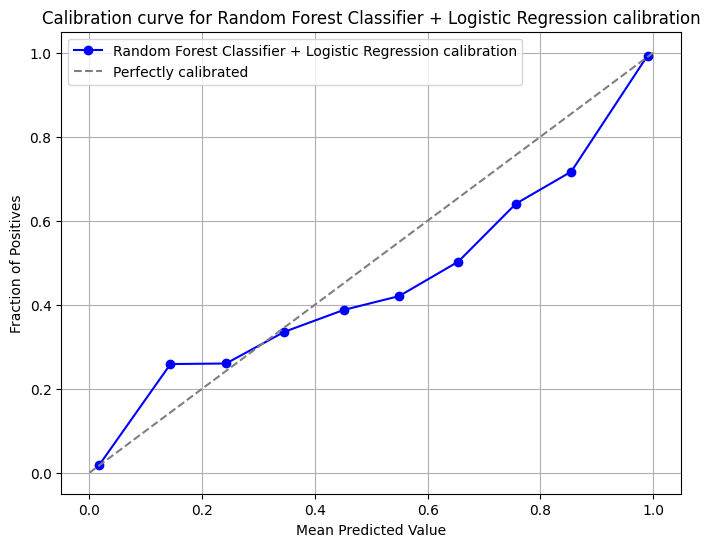

In [91]:
plot_calibration_curve(y_prob=y_prob_calibrated_model_logistic_regression_2,
                       y=y_val,
                       model_name='Random Forest Classifier + Logistic Regression calibration')

In [92]:
model_isotonic_regression_1 = IsotonicRegression(out_of_bounds='clip')
model_isotonic_regression_1.fit(y_prob_model_random_forest_classifier_1, y_val)
y_prob_calibrated_model_isotonic_regression_1 = model_isotonic_regression_1.transform(y_prob_model_random_forest_classifier_1)

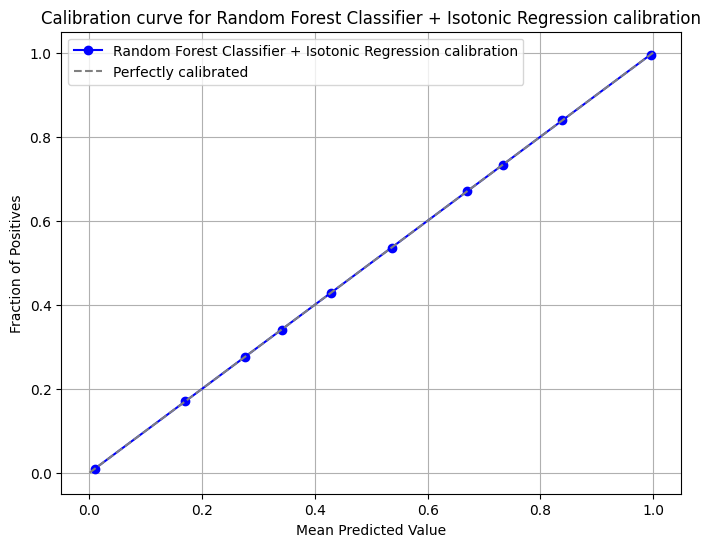

In [93]:
plot_calibration_curve(y_prob=y_prob_calibrated_model_isotonic_regression_1,
                       y=y_val,
                       model_name='Random Forest Classifier + Isotonic Regression calibration')

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)

Калибровка Платта - метод предполагает, что вероятности можно скорректировать с использованием логистической регрессии на выходах модели, эффективно работает, когда модель использует сигмоидную функцию, которая хорошо подходит для корректировки вероятностей.

https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

```
1) разброс и смещение для модели дерева решений
```

In [94]:
error_dt, bias_dt, var_dt = bias_variance_decomp(model_decision_tree_classifier_best,
                                                 X_train_enc.values,
                                                 y_train.values,
                                                 X_val_enc.values,
                                                 y_val.values,
                                                 loss='0-1_loss')
error_dt, bias_dt, var_dt

(0.05395359477124183, 0.04055555555555555, 0.03323431372549019)

```
2) разброс и смещение для модели случайного леса
```

In [95]:
error_dt, bias_dt, var_dt = bias_variance_decomp(model_random_forest_classifier_1,
                                                 X_train_enc.values,
                                                 y_train.values,
                                                 X_val_enc.values,
                                                 y_val.values,
                                                 loss='0-1_loss')
error_dt, bias_dt, var_dt

(0.04047549019607843, 0.039052287581699346, 0.009102941176470588)


```
Да, отличаются, смещение и разброс у RFC ниже чем у DTC - это соответствует теоритическим обоснованиям
```

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [96]:
error_dt, bias_dt, var_dt = bias_variance_decomp(model_logistic_regression_1,
                                                 X_train_scaled,
                                                 y_train.values,
                                                 X_val_scaled,
                                                 y_val.values,
                                                 loss='0-1_loss')
error_dt, bias_dt, var_dt

(0.12413513071895427, 0.12447712418300654, 0.00401421568627451)

```
ошибка и смещение у логистической регрессии выше, но разброс ниже, чем у RFC
```

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [97]:
from scipy.stats import uniform

param_dist = {
    'n_estimators': range(10, 101),
    'criterion': ['gini', 'entropy'],
    'max_depth': [int(x) for x in uniform(loc=1, scale=50).rvs(size=100)],
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11),
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), param_distributions=param_dist,
    n_iter=100, cv=5, scoring='neg_log_loss',
    verbose=1, random_state=42, n_jobs=-1
)
random_search.fit(X_train_enc, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [37, 2, 21, 14, 49, 32, 26,
                                                      37, 9, 44, 5, 32, 27, 50,
                                                      40, 20, 45, 46, 9, 16, 5,
                                                      6, 31, 20, 23, 35, 40, 37,
                                                      17, 39, ...],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': range(1, 11),
                                        'min_samples_split': range(2, 11),
                                        'n_estimators': range(10, 101)},
                   random_state=42, scoring='neg_log_loss', verbose=1)

In [98]:
random_search.best_params_

{'n_estimators': 46,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'entropy'}

In [99]:
model_random_forest_classifier_best = random_search.best_estimator_

In [100]:
y_predicted_val_model_random_forest_classifier_best = model_random_forest_classifier_best.predict(X_val_enc)
accuracy_score(y_val, y_predicted_val_model_random_forest_classifier_best)

0.9606535947712418

## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [101]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

/Users/denis.bobylev/Documents/hse/ml-hw/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/denis.bobylev/Documents/hse/ml-hw/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/denis.bobylev/Documents/hse/ml-hw/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/denis.bobylev/Documents/hse/ml-hw/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/d

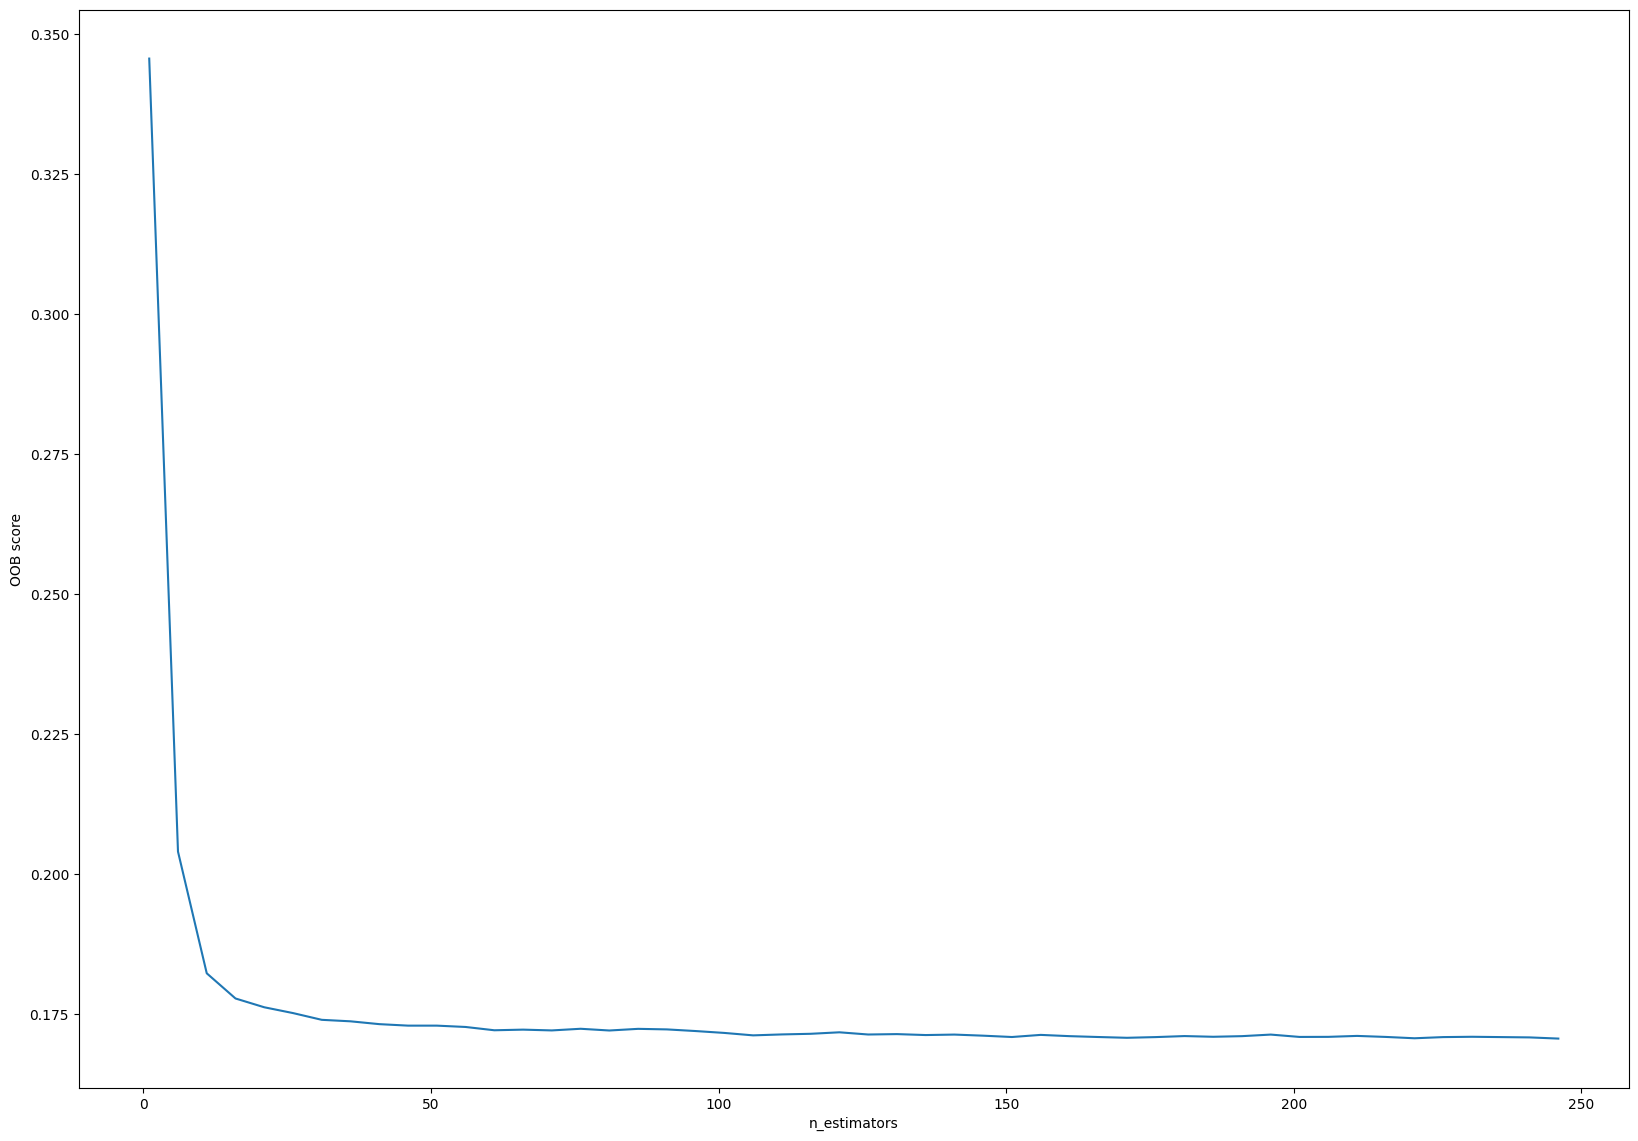

In [102]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [103]:
model_random_forest_classifier_best_feature_importances = model_random_forest_classifier_best.feature_importances_
model_random_forest_classifier_best_feature_importances

array([0.02948835, 0.02984417, 0.01011444, 0.01206756, 0.17023759,
       0.01553155, 0.04557189, 0.01495809, 0.01154236, 0.16893942,
       0.04766189, 0.05190851, 0.02746931, 0.04165244, 0.024829  ,
       0.02808493, 0.02587647, 0.02135292, 0.        , 0.00330939,
       0.        , 0.03992351, 0.        , 0.10602424, 0.        ,
       0.06691514, 0.00669683])

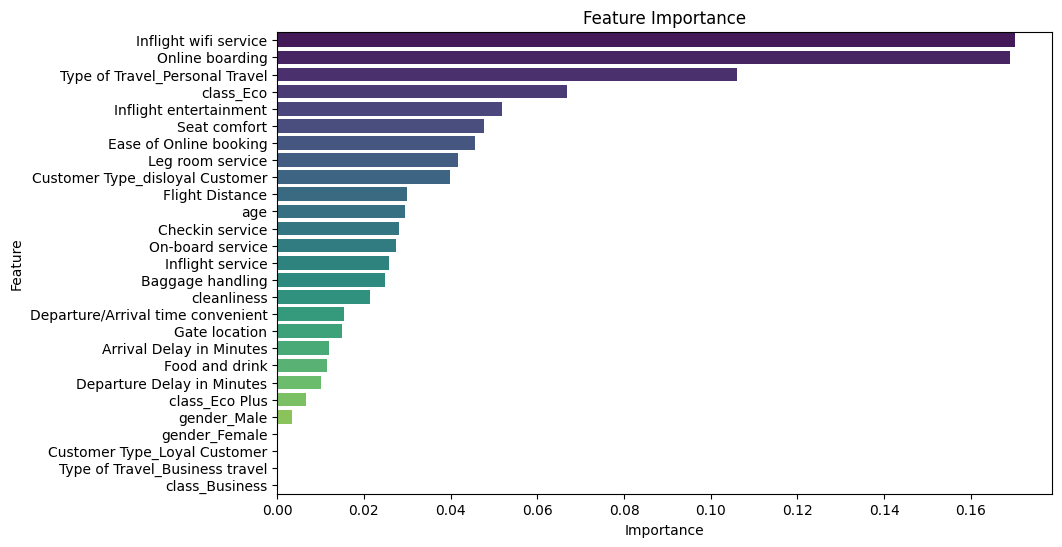

In [104]:
plot_feature_importances(list(X_train_enc.columns), model_random_forest_classifier_best_feature_importances)

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [105]:
with open('RFC.pkl', 'wb') as f:
    pickle.dump(model_random_forest_classifier_best, f)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [106]:
from shap.plots import beeswarm

In [107]:
X_val_enc_1000_sample = X_val_enc.sample(n=1000, random_state=42)

explainer = shap.TreeExplainer(model_random_forest_classifier_best)
shap_values = explainer(X_val_enc_1000_sample)

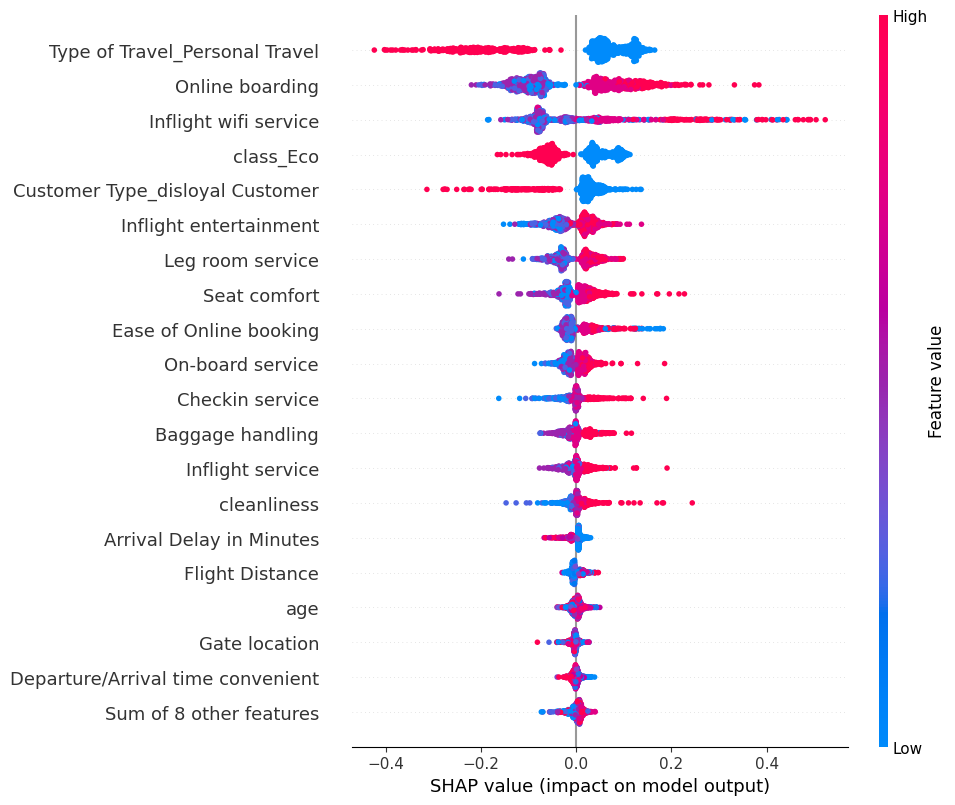

In [108]:
beeswarm(shap_values[:,:,1], max_display=20)

```
Видно, что наибольший импакт дают признаки Inflight Wifi Service, Online boarding, Type of Travel_Personal_Travel.

Мне кажется, что в идеале мы не должны видеть признак Type of Travel_Personal_Travel таким, что он вносит высокий вклад в модель,
в данном случае это означает некий дизбаланс, в тренировочных данных это видно, большинство пассажиров с Type of Travel=Personal_Travel, 
не удовлетворены сервисом, значит предсказания модели смещены, что и видно на графике интерпретации признаков
```

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [109]:
# Ваш код здесь


`Ваш ответ здесь`

## Котобонус!

0.25 балла

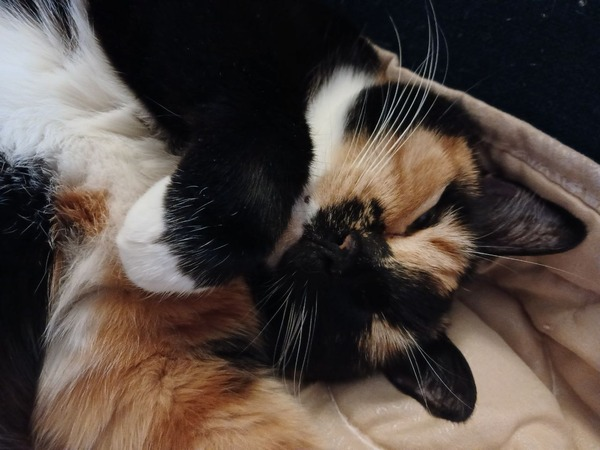

🤞 @murr4a

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

* хорошее дз, возможно для меня слишком тяжелое/объемное, к концу мотивация стала угасать
* хорошее, т.к. помогло понять, где есть пробелы/проблемы в знаниях
* хотелось бы уменьшить предвартительную часть (получение данных, EDA), сразу перейти к обучению модели,
чтобы более тонко понимать обучение и тюнинг параметров
* на дз ушло 8-10 часов чистого времени
* возможно стоит включить более осмысленную работу с каждой моделью, чтобы пытаться последовательно получить лучшее качество